### INST447 Project Part 1
#### Members: Alexander Chui and Matthew Chan

### What factors affect ratings for an anime?

## Libraries

In [1]:
#Importing the required libraries
import pandas as pd
from bs4 import BeautifulSoup
from urllib.request import urlopen 
import numpy as np
from requests import get

In [2]:
#libraries imported for handling rate limits and console formatting
from time import time, sleep
from random import randint
from warnings import warn
from IPython.core.display import clear_output

In [3]:
import regex

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis

C:\Users\MaNinjaChan\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\MaNinjaChan\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar'

Http response codes docs : https://developer.mozilla.org/en-US/docs/Web/HTTP/Status

## Web scraping

In [4]:
#Connecting to the URL on the web to access its content

html=urlopen('https://myanimelist.net/anime/genre/1/Action')
html.status

200

In [5]:
#Creating an instance of beautifulsoup object to begin web scraping

bs=BeautifulSoup(html.read(),'html.parser')

In [6]:
#Acessing the container objects with the anime info 

anime_containers = bs.find_all('div', {'class':{'seasonal-anime'}})
print(len(anime_containers))

100


In [7]:
#Creating empty lists to store all the items 

titles = []
data_of_releases = []
anime_ratings = []
# metascores = []
members = []
producers = []  
genre = []      
num_eps = []    
sources = []
formats = []    
licensors = []  
# box_office=[]

In [8]:
# Preparing the monitoring of the loop

start_time = time()
request = 0

In [9]:
#Extracting each job name in loop
for page in range(1,41):
    
    # Make a get request
        #https://myanimelist.net/anime/genre/1/Action?page=1
        #https://myanimelist.net/anime/genre/1/Action?page=2
        
        response = get('https://myanimelist.net/anime/genre/1/Action?page='+ str(page))
        
#         # Pause the loop
#         sleep(randint(8,15))

#         # Monitor the requests
#         request += 1
#         elapsed_time = time() - start_time
#         print('Request:{}; Frequency: {} requests/s'.format(request, 
#                                                             request/elapsed_time))
#         clear_output(wait = True)

#         # Throw a warning for non-200 status codes
#         if response.status_code != 200:
#             warn('Request: {}; Status code: {}'.format(request, 
#                                                        response.status_code))

#         # Break the loop if the number of requests is greater than expected
#         if request > 100:
#             warn('Number of requests was greater than expected.')
#             break
        
        # Parse the content of the request with BeautifulSoup
        bs = BeautifulSoup(response.text, 'html.parser')
        
        #Acessing the container objects with the anime info 
        anime_containers = bs.find_all('div', {'class':{'seasonal-anime'}})

        #Extracting all the elements 
        for container in anime_containers:
        # If the movie has Metascore, then extract:
        #  if container.find('div', {'class':{'scoremem'}})  is not None:
        
        # The name of anime
            try: 
                title = container.h2.a.text
                titles.append(title)
            except:
                titles.append('N/A')

        # The date of release (convert to date-time)
            try: 
                data_of_release = container.find('span',{'class':{'remain-time'}})
                data_of_releases.append(data_of_release.text)
            except:
                data_of_releases.append('N/A')

        # # The MAL rating
        #    anime_rating = float(container.strong.text)
        #    anime_ratings.append(anime_rating)

        # The anime score ratings
            try:
                anime_score = container.find('span', {'class':{'score'}})
                anime_ratings.append(float(anime_score.text))
            except:
                anime_ratings.append("N/A")

        # The number of members (convert string to int using str.replace)
            try: 
                member = container.find('span',{'class':{'member'}})
                members.append(member.text)
        #    members.append(int(member))
            except:
                members.append('N/A')

        # The producers / studio
        #    producer=container.find('span',{'class':'producer'})
            try: 
                producer = container.find('span',{'class':'producer'}).a.text
                producers.append(producer)
            except:
                producers.append('N/A')

        # Genre
            try: 
                gn = container.find('div',{'class':'genres-inner js-genre-inner'}).text
                genre.append(gn)
            except:
                genre.append('N/A')

        # The number of total episodes
            try: 
                num_ep = container.find('div',{'class':'eps'}).span.text
                num_eps.append(num_ep)
            except:
                num_eps.append('N/A')

        # The source of the anime
            try: 
                source = container.find('span',{'class':'source'}).text
                sources.append(source)
            except:
                sources.append('N/A')

        # The format of the anime
            try: 
                format_anime = container.find('div',{'class':'info'})
                formats.append(format_anime.text)
            except:
                formats.append('N/A')

        # The lincensor of the anime
            try: 
                licensor = container.find('p',{'class':'licensors'})['data-licensors']
                licensors.append(licensor)
            except:
                licensors.append('N/A')

        # Extracting box office collection

        #    try:
        #       bxc=container.find('p',{'class':{'sort-num_votes-visible'}}).text.split('\n')[4]
        #       box_office.append(bxc)
        #    except:
        #       box_office.append('0')

In [10]:
#Creating a pandas dataframe to store the objects extracted

anime_data = pd.DataFrame({'Anime Title': titles,
'Date of Release': data_of_releases,
'Score': anime_ratings,
'Member': members,
'Producer': producers,
'Genre': genre,
'Number of Episodes': num_eps,
'Sources': sources,
'Format': formats,
'Licensor': licensors
})
print(anime_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3977 entries, 0 to 3976
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Anime Title         3977 non-null   object
 1   Date of Release     3977 non-null   object
 2   Score               3977 non-null   object
 3   Member              3977 non-null   object
 4   Producer            3977 non-null   object
 5   Genre               3977 non-null   object
 6   Number of Episodes  3977 non-null   object
 7   Sources             3977 non-null   object
 8   Format              3977 non-null   object
 9   Licensor            3977 non-null   object
dtypes: object(10)
memory usage: 310.8+ KB
None


In [11]:
# Display the top 5 rows of dataset

anime_data.head()

,Anime Title,Date of Release,Score,Member,Producer,Genre,Number of Episodes,Sources,Format,Licensor
0,Shingeki no Kyojin,"\n Apr 7, 2013, 01:58 (JST) ...",8.5,"\n 2,801,951\n",Wit Studio,\nAction\n\nMilitary\n\nMystery\n\nSuper Power...,25 eps,Manga,"\n TV -\n \n Apr 7,...","Funimation,"
1,Fullmetal Alchemist: Brotherhood,"\n Apr 5, 2009, 17:00 (JST) ...",9.17,"\n 2,424,903\n",Bones,\nAction\n\nMilitary\n\nAdventure\n\nComedy\n\...,64 eps,Manga,"\n TV -\n \n Apr 5,...","Aniplex of America,Funimation,"
2,Sword Art Online,"\n Jul 8, 2012, 00:00 (JST) ...",7.22,"\n 2,375,868\n",A-1 Pictures,\nAction\n\nGame\n\nAdventure\n\nRomance\n\nFa...,25 eps,Light novel,"\n TV -\n \n Jul 8,...","Aniplex of America,"
3,One Punch Man,"\n Oct 5, 2015, 01:05 (JST) ...",8.55,"\n 2,308,824\n",Madhouse,\nAction\n\nSci-Fi\n\nComedy\n\nParody\n\nSupe...,12 eps,Web manga,"\n TV -\n \n Oct 5,...","VIZ Media,"
4,Boku no Hero Academia,"\n Apr 3, 2016, 17:00 (JST) ...",8.05,"\n 2,139,153\n",Bones,\nAction\n\nComedy\n\nSchool\n\nShounen\n\nSup...,13 eps,Manga,"\n TV -\n \n Apr 3,...","Funimation,"


#### Genre Cleaning

In [12]:
# In Genre Column, remove all the “\n\n” (newline) characters in your dataset 
# and print the first 5 rows of data.

anime_data['Genre'] = anime_data['Genre'].replace('\n\n',',', regex=True)

anime_data.head()

,Anime Title,Date of Release,Score,Member,Producer,Genre,Number of Episodes,Sources,Format,Licensor
0,Shingeki no Kyojin,"\n Apr 7, 2013, 01:58 (JST) ...",8.5,"\n 2,801,951\n",Wit Studio,"\nAction,Military,Mystery,Super Power,Drama,Fa...",25 eps,Manga,"\n TV -\n \n Apr 7,...","Funimation,"
1,Fullmetal Alchemist: Brotherhood,"\n Apr 5, 2009, 17:00 (JST) ...",9.17,"\n 2,424,903\n",Bones,"\nAction,Military,Adventure,Comedy,Drama,Magic...",64 eps,Manga,"\n TV -\n \n Apr 5,...","Aniplex of America,Funimation,"
2,Sword Art Online,"\n Jul 8, 2012, 00:00 (JST) ...",7.22,"\n 2,375,868\n",A-1 Pictures,"\nAction,Game,Adventure,Romance,Fantasy\n",25 eps,Light novel,"\n TV -\n \n Jul 8,...","Aniplex of America,"
3,One Punch Man,"\n Oct 5, 2015, 01:05 (JST) ...",8.55,"\n 2,308,824\n",Madhouse,"\nAction,Sci-Fi,Comedy,Parody,Super Power,Supe...",12 eps,Web manga,"\n TV -\n \n Oct 5,...","VIZ Media,"
4,Boku no Hero Academia,"\n Apr 3, 2016, 17:00 (JST) ...",8.05,"\n 2,139,153\n",Bones,"\nAction,Comedy,School,Shounen,Super Power\n",13 eps,Manga,"\n TV -\n \n Apr 3,...","Funimation,"


#### Removing newline

In [13]:
# In all columns, remove all the “\n” (newline) characters in your dataset and 
# print the first 5 rows of data.

anime_data = anime_data.replace('\n','', regex=True)

anime_data.head()

,Anime Title,Date of Release,Score,Member,Producer,Genre,Number of Episodes,Sources,Format,Licensor
0,Shingeki no Kyojin,"Apr 7, 2013, 01:58 (JST) ...",8.5,"2,801,951",Wit Studio,"Action,Military,Mystery,Super Power,Drama,Fant...",25 eps,Manga,"TV - Apr 7, 2013,...","Funimation,"
1,Fullmetal Alchemist: Brotherhood,"Apr 5, 2009, 17:00 (JST) ...",9.17,"2,424,903",Bones,"Action,Military,Adventure,Comedy,Drama,Magic,F...",64 eps,Manga,"TV - Apr 5, 2009,...","Aniplex of America,Funimation,"
2,Sword Art Online,"Jul 8, 2012, 00:00 (JST) ...",7.22,"2,375,868",A-1 Pictures,"Action,Game,Adventure,Romance,Fantasy",25 eps,Light novel,"TV - Jul 8, 2012,...","Aniplex of America,"
3,One Punch Man,"Oct 5, 2015, 01:05 (JST) ...",8.55,"2,308,824",Madhouse,"Action,Sci-Fi,Comedy,Parody,Super Power,Supern...",12 eps,Web manga,"TV - Oct 5, 2015,...","VIZ Media,"
4,Boku no Hero Academia,"Apr 3, 2016, 17:00 (JST) ...",8.05,"2,139,153",Bones,"Action,Comedy,School,Shounen,Super Power",13 eps,Manga,"TV - Apr 3, 2016,...","Funimation,"


#### Member Cleaning

In [14]:
# In Member column, remove all the “,” characters in your member column and 
# print the first 5 rows of data.

anime_data['Member'] = anime_data['Member'].replace(',','', regex=True)

anime_data.head()

,Anime Title,Date of Release,Score,Member,Producer,Genre,Number of Episodes,Sources,Format,Licensor
0,Shingeki no Kyojin,"Apr 7, 2013, 01:58 (JST) ...",8.5,2801951,Wit Studio,"Action,Military,Mystery,Super Power,Drama,Fant...",25 eps,Manga,"TV - Apr 7, 2013,...","Funimation,"
1,Fullmetal Alchemist: Brotherhood,"Apr 5, 2009, 17:00 (JST) ...",9.17,2424903,Bones,"Action,Military,Adventure,Comedy,Drama,Magic,F...",64 eps,Manga,"TV - Apr 5, 2009,...","Aniplex of America,Funimation,"
2,Sword Art Online,"Jul 8, 2012, 00:00 (JST) ...",7.22,2375868,A-1 Pictures,"Action,Game,Adventure,Romance,Fantasy",25 eps,Light novel,"TV - Jul 8, 2012,...","Aniplex of America,"
3,One Punch Man,"Oct 5, 2015, 01:05 (JST) ...",8.55,2308824,Madhouse,"Action,Sci-Fi,Comedy,Parody,Super Power,Supern...",12 eps,Web manga,"TV - Oct 5, 2015,...","VIZ Media,"
4,Boku no Hero Academia,"Apr 3, 2016, 17:00 (JST) ...",8.05,2139153,Bones,"Action,Comedy,School,Shounen,Super Power",13 eps,Manga,"TV - Apr 3, 2016,...","Funimation,"


In [15]:
# Using pd.to_numeric with errors=coerce to substitute your non numeric 
# values with NaN and apply it the each column. Then you could use dropna or 
# fillna whatever you prefer. 
# anime_data[['Score', 'Member']] = anime_data[['Score', 'Member']].apply(pd.to_numeric(anime_data['Score'], downcast="float"), errors='coerce')

anime_data[['Score', 'Member']] = anime_data[['Score', 'Member']].apply(pd.to_numeric, errors='coerce')

new_anime_data = anime_data.dropna()

#### Reindexing

In [16]:
#Reset index of missing_bo for smooth concatenation 

new_anime_data.reset_index(drop=True, inplace=True)

In [17]:
new_anime_data.head()

,Anime Title,Date of Release,Score,Member,Producer,Genre,Number of Episodes,Sources,Format,Licensor
0,Shingeki no Kyojin,"Apr 7, 2013, 01:58 (JST) ...",8.50,2801951,Wit Studio,"Action,Military,Mystery,Super Power,Drama,Fant...",25 eps,Manga,"TV - Apr 7, 2013,...","Funimation,"
1,Fullmetal Alchemist: Brotherhood,"Apr 5, 2009, 17:00 (JST) ...",9.17,2424903,Bones,"Action,Military,Adventure,Comedy,Drama,Magic,F...",64 eps,Manga,"TV - Apr 5, 2009,...","Aniplex of America,Funimation,"
2,Sword Art Online,"Jul 8, 2012, 00:00 (JST) ...",7.22,2375868,A-1 Pictures,"Action,Game,Adventure,Romance,Fantasy",25 eps,Light novel,"TV - Jul 8, 2012,...","Aniplex of America,"
3,One Punch Man,"Oct 5, 2015, 01:05 (JST) ...",8.55,2308824,Madhouse,"Action,Sci-Fi,Comedy,Parody,Super Power,Supern...",12 eps,Web manga,"TV - Oct 5, 2015,...","VIZ Media,"
4,Boku no Hero Academia,"Apr 3, 2016, 17:00 (JST) ...",8.05,2139153,Bones,"Action,Comedy,School,Shounen,Super Power",13 eps,Manga,"TV - Apr 3, 2016,...","Funimation,"


## Summary Statistics

In [18]:
# Summary stats for columns Score and Member

new_anime_data[['Score', 'Member']].describe()

,Score,Member
count,3394.000000,3.394000e+03
mean,6.737392,8.694789e+04
std,0.854869,2.259284e+05
min,2.490000,1.930000e+02
25%,6.200000,2.688250e+03
50%,6.770000,1.223600e+04
75%,7.327500,6.325275e+04
max,9.170000,2.801951e+06


In [19]:
#Checking for the number of producers in column of Producer

new_anime_data['Producer'].value_counts()

N/A                   469
Toei Animation        240
Sunrise               237
Madhouse              111
Production I.G        101
                     ... 
Congzhuo Animation      1
Namu Animation          1
Visual 80               1
TAKI Corporation        1
Public & Basic          1
Name: Producer, Length: 300, dtype: int64

In [20]:
#Checking for the number of producers in column of Producer

new_anime_data['Producer'].value_counts().head(10)

N/A               469
Toei Animation    240
Sunrise           237
Madhouse          111
Production I.G    101
J.C.Staff          92
Studio Pierrot     90
OLM                85
A-1 Pictures       83
Studio Deen        82
Name: Producer, dtype: int64

In [21]:
# Checking for the number of episodes in column of Number of Episodes

new_anime_data['Number of Episodes'].value_counts()

1 ep       1371
12 eps      430
13 eps      205
2 eps       176
26 eps      146
           ... 
66 eps        1
61 eps        1
178 eps       1
180 eps       1
67 eps        1
Name: Number of Episodes, Length: 114, dtype: int64

In [22]:
#Checking for the number of sources in column of Sources

new_anime_data['Sources'].value_counts()

Manga           1107
Original         891
-                408
Game             343
Light novel      263
Novel            144
Other             83
Visual novel      77
Web manga         51
Card game         13
Music              5
Book               4
Radio              2
4-koma manga       2
Picture book       1
Name: Sources, dtype: int64

In [23]:
#Checking for the number of licensors in column of Licensor

new_anime_data['Licensor'].value_counts()

                                                       1759
Funimation,                                             447
Sentai Filmworks,                                       202
Discotek Media,                                          94
VIZ Media,                                               87
                                                       ... 
ADV Films,Funimation,OLM Digital,                         1
Discotek Media,Nozomi Entertainment,                      1
DreamWorks,Eleven Arts,                                   1
Discotek Media,Ponycan USA,                               1
Bandai Visual USA,Maiden Japan,Manga Entertainment,       1
Name: Licensor, Length: 153, dtype: int64

In [24]:
# Getting basic information about the new anime dataset

print(new_anime_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3394 entries, 0 to 3393
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Anime Title         3394 non-null   object 
 1   Date of Release     3394 non-null   object 
 2   Score               3394 non-null   float64
 3   Member              3394 non-null   int64  
 4   Producer            3394 non-null   object 
 5   Genre               3394 non-null   object 
 6   Number of Episodes  3394 non-null   object 
 7   Sources             3394 non-null   object 
 8   Format              3394 non-null   object 
 9   Licensor            3394 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 265.3+ KB
None


### Date of Release Cleaning

In [25]:
# Creating new dataframe for anime time only

anime_time = new_anime_data
anime_time.dtypes
anime_time.head()

,Anime Title,Date of Release,Score,Member,Producer,Genre,Number of Episodes,Sources,Format,Licensor
0,Shingeki no Kyojin,"Apr 7, 2013, 01:58 (JST) ...",8.50,2801951,Wit Studio,"Action,Military,Mystery,Super Power,Drama,Fant...",25 eps,Manga,"TV - Apr 7, 2013,...","Funimation,"
1,Fullmetal Alchemist: Brotherhood,"Apr 5, 2009, 17:00 (JST) ...",9.17,2424903,Bones,"Action,Military,Adventure,Comedy,Drama,Magic,F...",64 eps,Manga,"TV - Apr 5, 2009,...","Aniplex of America,Funimation,"
2,Sword Art Online,"Jul 8, 2012, 00:00 (JST) ...",7.22,2375868,A-1 Pictures,"Action,Game,Adventure,Romance,Fantasy",25 eps,Light novel,"TV - Jul 8, 2012,...","Aniplex of America,"
3,One Punch Man,"Oct 5, 2015, 01:05 (JST) ...",8.55,2308824,Madhouse,"Action,Sci-Fi,Comedy,Parody,Super Power,Supern...",12 eps,Web manga,"TV - Oct 5, 2015,...","VIZ Media,"
4,Boku no Hero Academia,"Apr 3, 2016, 17:00 (JST) ...",8.05,2139153,Bones,"Action,Comedy,School,Shounen,Super Power",13 eps,Manga,"TV - Apr 3, 2016,...","Funimation,"


In [26]:
# Checking Date of Release column

print(anime_time['Date of Release'])

0                         Apr 7, 2013, 01:58 (JST)    ...
1                         Apr 5, 2009, 17:00 (JST)    ...
2                         Jul 8, 2012, 00:00 (JST)    ...
3                         Oct 5, 2015, 01:05 (JST)    ...
4                         Apr 3, 2016, 17:00 (JST)    ...
                              ...                        
3389                           Jun 15, 2009              
3390                            Jul 6, 2016              
3391                           Apr ??, 1994              
3392                            Mar 6, 2019              
3393                           Apr 22, 2012              
Name: Date of Release, Length: 3394, dtype: object


In [27]:
# In Date of Release column, remove all the “ ” characters in your Date of 
# Release column and print the first 5 rows of data.

anime_time['Date of Release'] = anime_time['Date of Release'].replace('  ','', regex=True)
anime_time['Date of Release'].head()

<ipython-input-27-7de873bf68b2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_time['Date of Release'] = anime_time['Date of Release'].replace('  ','', regex=True)


0    Apr 7, 2013, 01:58 (JST)
1    Apr 5, 2009, 17:00 (JST)
2    Jul 8, 2012, 00:00 (JST)
3    Oct 5, 2015, 01:05 (JST)
4    Apr 3, 2016, 17:00 (JST)
Name: Date of Release, dtype: object

In [28]:
#Splitting the Date of Release into multiple columns and adding it back to the anime_time dataset
import numpy as np

anime_time = anime_time.join(anime_time['Date of Release'].str.split(' ', expand=True).add_prefix('Date of Release').fillna(np.nan))
anime_time.head()

,Anime Title,Date of Release,Score,Member,Producer,Genre,Number of Episodes,Sources,Format,Licensor,Date of Release0,Date of Release1,Date of Release2,Date of Release3,Date of Release4
0,Shingeki no Kyojin,"Apr 7, 2013, 01:58 (JST)",8.50,2801951,Wit Studio,"Action,Military,Mystery,Super Power,Drama,Fant...",25 eps,Manga,"TV - Apr 7, 2013,...","Funimation,",Apr,"7,","2013,",01:58,(JST)
1,Fullmetal Alchemist: Brotherhood,"Apr 5, 2009, 17:00 (JST)",9.17,2424903,Bones,"Action,Military,Adventure,Comedy,Drama,Magic,F...",64 eps,Manga,"TV - Apr 5, 2009,...","Aniplex of America,Funimation,",Apr,"5,","2009,",17:00,(JST)
2,Sword Art Online,"Jul 8, 2012, 00:00 (JST)",7.22,2375868,A-1 Pictures,"Action,Game,Adventure,Romance,Fantasy",25 eps,Light novel,"TV - Jul 8, 2012,...","Aniplex of America,",Jul,"8,","2012,",00:00,(JST)
3,One Punch Man,"Oct 5, 2015, 01:05 (JST)",8.55,2308824,Madhouse,"Action,Sci-Fi,Comedy,Parody,Super Power,Supern...",12 eps,Web manga,"TV - Oct 5, 2015,...","VIZ Media,",Oct,"5,","2015,",01:05,(JST)
4,Boku no Hero Academia,"Apr 3, 2016, 17:00 (JST)",8.05,2139153,Bones,"Action,Comedy,School,Shounen,Super Power",13 eps,Manga,"TV - Apr 3, 2016,...","Funimation,",Apr,"3,","2016,",17:00,(JST)


#### Date of Release (Months)

In [29]:
# Checking for the number of anime released in Months

anime_time['Date of Release0'].value_counts()

Apr    541
Oct    538
Jul    449
Jan    332
Dec    258
Mar    233
Aug    190
Sep    189
Feb    173
Nov    163
Jun    135
May    127
???     66
Name: Date of Release0, dtype: int64

#### Renaming Date of Release0

In [30]:
# Renaming Date of Release0 to Date of Release (Months)

anime_time['Date of Release (Months)'] = anime_time['Date of Release0']
anime_time.head()

,Anime Title,Date of Release,Score,Member,Producer,Genre,Number of Episodes,Sources,Format,Licensor,Date of Release0,Date of Release1,Date of Release2,Date of Release3,Date of Release4,Date of Release (Months)
0,Shingeki no Kyojin,"Apr 7, 2013, 01:58 (JST)",8.50,2801951,Wit Studio,"Action,Military,Mystery,Super Power,Drama,Fant...",25 eps,Manga,"TV - Apr 7, 2013,...","Funimation,",Apr,"7,","2013,",01:58,(JST),Apr
1,Fullmetal Alchemist: Brotherhood,"Apr 5, 2009, 17:00 (JST)",9.17,2424903,Bones,"Action,Military,Adventure,Comedy,Drama,Magic,F...",64 eps,Manga,"TV - Apr 5, 2009,...","Aniplex of America,Funimation,",Apr,"5,","2009,",17:00,(JST),Apr
2,Sword Art Online,"Jul 8, 2012, 00:00 (JST)",7.22,2375868,A-1 Pictures,"Action,Game,Adventure,Romance,Fantasy",25 eps,Light novel,"TV - Jul 8, 2012,...","Aniplex of America,",Jul,"8,","2012,",00:00,(JST),Jul
3,One Punch Man,"Oct 5, 2015, 01:05 (JST)",8.55,2308824,Madhouse,"Action,Sci-Fi,Comedy,Parody,Super Power,Supern...",12 eps,Web manga,"TV - Oct 5, 2015,...","VIZ Media,",Oct,"5,","2015,",01:05,(JST),Oct
4,Boku no Hero Academia,"Apr 3, 2016, 17:00 (JST)",8.05,2139153,Bones,"Action,Comedy,School,Shounen,Super Power",13 eps,Manga,"TV - Apr 3, 2016,...","Funimation,",Apr,"3,","2016,",17:00,(JST),Apr


#### Date of Release1 Cleaning

In [31]:
# In Date of Release1 column, remove all the “,” characters in your Date of 
# Release1 column and print the first 5 rows of data.

anime_time['Date of Release1'] = anime_time['Date of Release1'].replace(',','', regex=True)
anime_time['Date of Release1'].head()

0    7
1    5
2    8
3    5
4    3
Name: Date of Release1, dtype: object

#### Date of Release (Day of the Month)

In [32]:
# Checking for the number of anime released in day of month

anime_time['Date of Release1'].value_counts()

3     188
7     180
25    176
6     175
5     172
4     166
21    163
1     158
2     155
8     153
9     121
10    109
26     91
13     88
11     86
27     84
??     84
12     83
22     83
16     79
20     78
24     78
23     77
15     70
18     69
29     68
28     68
17     68
14     68
19     54
31     53
30     49
Name: Date of Release1, dtype: int64

#### Renaming Date of Release1 

In [33]:
# Renaming Date of Release1 to Date of Release (Day of Month)

anime_time['Date of Release (Day of Month)'] = anime_time['Date of Release1']
anime_time.head()

,Anime Title,Date of Release,Score,Member,Producer,Genre,Number of Episodes,Sources,Format,Licensor,Date of Release0,Date of Release1,Date of Release2,Date of Release3,Date of Release4,Date of Release (Months),Date of Release (Day of Month)
0,Shingeki no Kyojin,"Apr 7, 2013, 01:58 (JST)",8.50,2801951,Wit Studio,"Action,Military,Mystery,Super Power,Drama,Fant...",25 eps,Manga,"TV - Apr 7, 2013,...","Funimation,",Apr,7,"2013,",01:58,(JST),Apr,7
1,Fullmetal Alchemist: Brotherhood,"Apr 5, 2009, 17:00 (JST)",9.17,2424903,Bones,"Action,Military,Adventure,Comedy,Drama,Magic,F...",64 eps,Manga,"TV - Apr 5, 2009,...","Aniplex of America,Funimation,",Apr,5,"2009,",17:00,(JST),Apr,5
2,Sword Art Online,"Jul 8, 2012, 00:00 (JST)",7.22,2375868,A-1 Pictures,"Action,Game,Adventure,Romance,Fantasy",25 eps,Light novel,"TV - Jul 8, 2012,...","Aniplex of America,",Jul,8,"2012,",00:00,(JST),Jul,8
3,One Punch Man,"Oct 5, 2015, 01:05 (JST)",8.55,2308824,Madhouse,"Action,Sci-Fi,Comedy,Parody,Super Power,Supern...",12 eps,Web manga,"TV - Oct 5, 2015,...","VIZ Media,",Oct,5,"2015,",01:05,(JST),Oct,5
4,Boku no Hero Academia,"Apr 3, 2016, 17:00 (JST)",8.05,2139153,Bones,"Action,Comedy,School,Shounen,Super Power",13 eps,Manga,"TV - Apr 3, 2016,...","Funimation,",Apr,3,"2016,",17:00,(JST),Apr,3


#### Date of Release2 Cleaning

In [34]:
# In Date of Release2 column, remove all the “,” characters in your Date of 
# Release2 column and print the first 5 rows of data.

anime_time['Date of Release2'] = anime_time['Date of Release2'].replace(',','', regex=True)
anime_time['Date of Release2'].head()

0    2013
1    2009
2    2012
3    2015
4    2016
Name: Date of Release2, dtype: object

#### Date of Release (Year)

In [35]:
# Checking for the number of anime released in the year

anime_time['Date of Release2'].value_counts()

2018    200
2016    178
2019    165
2015    160
2017    159
       ... 
1939      1
1966      1
1941      1
1945      1
1952      1
Name: Date of Release2, Length: 74, dtype: int64

#### Date of Release2 Renaming

In [36]:
# Renaming Date of Release2 to Date of Release (Year)

anime_time['Date of Release (Year)'] = anime_time['Date of Release2']
anime_time.head()

,Anime Title,Date of Release,Score,Member,Producer,Genre,Number of Episodes,Sources,Format,Licensor,Date of Release0,Date of Release1,Date of Release2,Date of Release3,Date of Release4,Date of Release (Months),Date of Release (Day of Month),Date of Release (Year)
0,Shingeki no Kyojin,"Apr 7, 2013, 01:58 (JST)",8.50,2801951,Wit Studio,"Action,Military,Mystery,Super Power,Drama,Fant...",25 eps,Manga,"TV - Apr 7, 2013,...","Funimation,",Apr,7,2013,01:58,(JST),Apr,7,2013
1,Fullmetal Alchemist: Brotherhood,"Apr 5, 2009, 17:00 (JST)",9.17,2424903,Bones,"Action,Military,Adventure,Comedy,Drama,Magic,F...",64 eps,Manga,"TV - Apr 5, 2009,...","Aniplex of America,Funimation,",Apr,5,2009,17:00,(JST),Apr,5,2009
2,Sword Art Online,"Jul 8, 2012, 00:00 (JST)",7.22,2375868,A-1 Pictures,"Action,Game,Adventure,Romance,Fantasy",25 eps,Light novel,"TV - Jul 8, 2012,...","Aniplex of America,",Jul,8,2012,00:00,(JST),Jul,8,2012
3,One Punch Man,"Oct 5, 2015, 01:05 (JST)",8.55,2308824,Madhouse,"Action,Sci-Fi,Comedy,Parody,Super Power,Supern...",12 eps,Web manga,"TV - Oct 5, 2015,...","VIZ Media,",Oct,5,2015,01:05,(JST),Oct,5,2015
4,Boku no Hero Academia,"Apr 3, 2016, 17:00 (JST)",8.05,2139153,Bones,"Action,Comedy,School,Shounen,Super Power",13 eps,Manga,"TV - Apr 3, 2016,...","Funimation,",Apr,3,2016,17:00,(JST),Apr,3,2016


#### Date of Release Deleting Columns

In [37]:
# Deleting Columns Date of Release 0, 1, and 2 as they are unnecessary and not 
# needed. As well as columns Date of Release 3 and 4 as we don't need these

# anime_time.drop(['Date of Release0','Date of Release1','Date of Release2'], axis = 1)
del anime_time['Date of Release0']
del anime_time['Date of Release1']
del anime_time['Date of Release2']
del anime_time['Date of Release3']
del anime_time['Date of Release4']

anime_time.head()

,Anime Title,Date of Release,Score,Member,Producer,Genre,Number of Episodes,Sources,Format,Licensor,Date of Release (Months),Date of Release (Day of Month),Date of Release (Year)
0,Shingeki no Kyojin,"Apr 7, 2013, 01:58 (JST)",8.50,2801951,Wit Studio,"Action,Military,Mystery,Super Power,Drama,Fant...",25 eps,Manga,"TV - Apr 7, 2013,...","Funimation,",Apr,7,2013
1,Fullmetal Alchemist: Brotherhood,"Apr 5, 2009, 17:00 (JST)",9.17,2424903,Bones,"Action,Military,Adventure,Comedy,Drama,Magic,F...",64 eps,Manga,"TV - Apr 5, 2009,...","Aniplex of America,Funimation,",Apr,5,2009
2,Sword Art Online,"Jul 8, 2012, 00:00 (JST)",7.22,2375868,A-1 Pictures,"Action,Game,Adventure,Romance,Fantasy",25 eps,Light novel,"TV - Jul 8, 2012,...","Aniplex of America,",Jul,8,2012
3,One Punch Man,"Oct 5, 2015, 01:05 (JST)",8.55,2308824,Madhouse,"Action,Sci-Fi,Comedy,Parody,Super Power,Supern...",12 eps,Web manga,"TV - Oct 5, 2015,...","VIZ Media,",Oct,5,2015
4,Boku no Hero Academia,"Apr 3, 2016, 17:00 (JST)",8.05,2139153,Bones,"Action,Comedy,School,Shounen,Super Power",13 eps,Manga,"TV - Apr 3, 2016,...","Funimation,",Apr,3,2016


#### Date of Release Cleaning

In [38]:
# Combining columns Date of Release (Year), Date of Release (Months), and Date
# of Release (Day of Month)

anime_time['Date of Release YMD'] = anime_time['Date of Release (Year)'].astype(str)+ " " +anime_time['Date of Release (Months)']+" " +anime_time['Date of Release (Day of Month)'].astype(str)

anime_time.head()

,Anime Title,Date of Release,Score,Member,Producer,Genre,Number of Episodes,Sources,Format,Licensor,Date of Release (Months),Date of Release (Day of Month),Date of Release (Year),Date of Release YMD
0,Shingeki no Kyojin,"Apr 7, 2013, 01:58 (JST)",8.50,2801951,Wit Studio,"Action,Military,Mystery,Super Power,Drama,Fant...",25 eps,Manga,"TV - Apr 7, 2013,...","Funimation,",Apr,7,2013,2013 Apr 7
1,Fullmetal Alchemist: Brotherhood,"Apr 5, 2009, 17:00 (JST)",9.17,2424903,Bones,"Action,Military,Adventure,Comedy,Drama,Magic,F...",64 eps,Manga,"TV - Apr 5, 2009,...","Aniplex of America,Funimation,",Apr,5,2009,2009 Apr 5
2,Sword Art Online,"Jul 8, 2012, 00:00 (JST)",7.22,2375868,A-1 Pictures,"Action,Game,Adventure,Romance,Fantasy",25 eps,Light novel,"TV - Jul 8, 2012,...","Aniplex of America,",Jul,8,2012,2012 Jul 8
3,One Punch Man,"Oct 5, 2015, 01:05 (JST)",8.55,2308824,Madhouse,"Action,Sci-Fi,Comedy,Parody,Super Power,Supern...",12 eps,Web manga,"TV - Oct 5, 2015,...","VIZ Media,",Oct,5,2015,2015 Oct 5
4,Boku no Hero Academia,"Apr 3, 2016, 17:00 (JST)",8.05,2139153,Bones,"Action,Comedy,School,Shounen,Super Power",13 eps,Manga,"TV - Apr 3, 2016,...","Funimation,",Apr,3,2016,2016 Apr 3


#### Date of Release YMD column changing datatype object to datetime64[ns]

In [39]:
# Converting Date of Release YMD column into datetime64[ns] format

import datetime as dt
from datetime import datetime

anime_time2 = anime_time

anime_time2['Date of Release YMD'] = pd.to_datetime(anime_time2['Date of Release YMD'], dayfirst=True, errors='coerce')

In [40]:
# Checking count of anime by Month datetime

mnth_counts = anime_time2['Date of Release YMD'].dt.month_name().value_counts()
mnth_counts

April        537
October      536
July         446
January      330
December     257
March        232
September    189
August       189
February     173
November     161
June         134
May          126
Name: Date of Release YMD, dtype: int64

<AxesSubplot:title={'center':'All Anime Monthly'}>

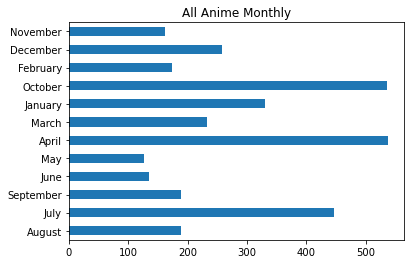

In [41]:
#Plotting the number of monthly anime from 1952-2018 in barchart

months = ['August', 'July','September','June','May','April','March','January','October','February','December','November']
title = 'All Anime Monthly'
mnth_counts.reindex(months).plot(kind='barh', title=title)

In [42]:
#Setting the date column as the index 

anime_retime=anime_time2.set_index('Date of Release YMD')
anime_retime.head()

,Anime Title,Date of Release,Score,Member,Producer,Genre,Number of Episodes,Sources,Format,Licensor,Date of Release (Months),Date of Release (Day of Month),Date of Release (Year)
Date of Release YMD,,,,,,,,,,,,,
2013-04-07,Shingeki no Kyojin,"Apr 7, 2013, 01:58 (JST)",8.50,2801951,Wit Studio,"Action,Military,Mystery,Super Power,Drama,Fant...",25 eps,Manga,"TV - Apr 7, 2013,...","Funimation,",Apr,7,2013
2009-04-05,Fullmetal Alchemist: Brotherhood,"Apr 5, 2009, 17:00 (JST)",9.17,2424903,Bones,"Action,Military,Adventure,Comedy,Drama,Magic,F...",64 eps,Manga,"TV - Apr 5, 2009,...","Aniplex of America,Funimation,",Apr,5,2009
2012-07-08,Sword Art Online,"Jul 8, 2012, 00:00 (JST)",7.22,2375868,A-1 Pictures,"Action,Game,Adventure,Romance,Fantasy",25 eps,Light novel,"TV - Jul 8, 2012,...","Aniplex of America,",Jul,8,2012
2015-10-05,One Punch Man,"Oct 5, 2015, 01:05 (JST)",8.55,2308824,Madhouse,"Action,Sci-Fi,Comedy,Parody,Super Power,Supern...",12 eps,Web manga,"TV - Oct 5, 2015,...","VIZ Media,",Oct,5,2015
2016-04-03,Boku no Hero Academia,"Apr 3, 2016, 17:00 (JST)",8.05,2139153,Bones,"Action,Comedy,School,Shounen,Super Power",13 eps,Manga,"TV - Apr 3, 2016,...","Funimation,",Apr,3,2016


In [43]:
mnthly_anime = anime_retime.resample('M').size()
mnthly_anime.head()

Date of Release YMD
1929-03-31    1
1929-04-30    0
1929-05-31    0
1929-06-30    1
1929-07-31    0
dtype: int64

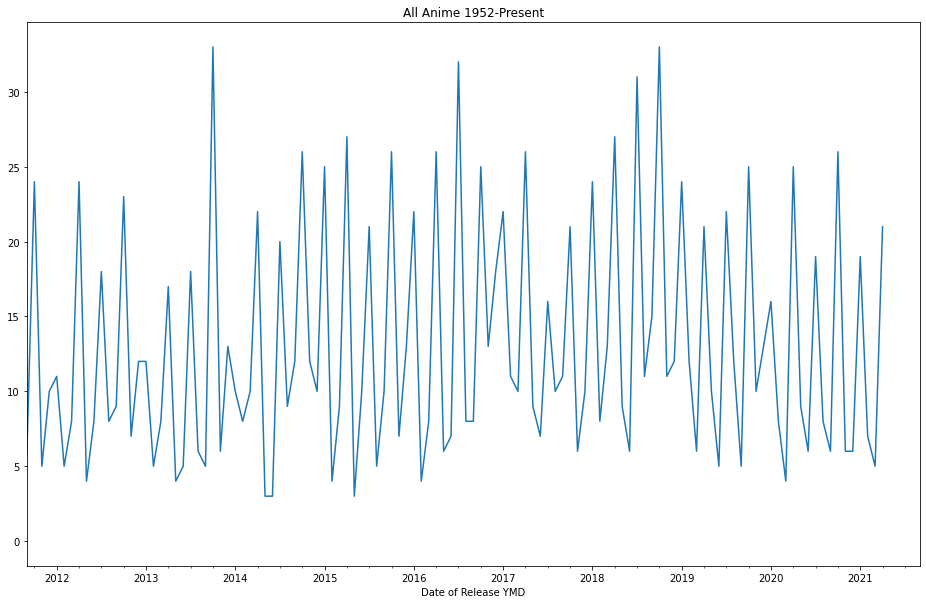

In [44]:
#Plotting the number of anime from 1952-Present
import matplotlib.pyplot as plt
import numpy as np

fig = mnthly_anime.plot(figsize=(16, 10), title='All Anime 1952-Present')
plt.xlim([500,620])
plt.show()

### Saving Dataframe anime_time1 & 2 to csv

In [45]:
# anime_time.to_csv(r'D:\UMD Senior College Work\Spring 2021\INST447-0101\Final Project\INST447 Project Part 1 Time.csv', index = False)

In [46]:
# anime_time2.to_csv(r'D:\UMD Senior College Work\Spring 2021\INST447-0101\Final Project\INST447 Project Part 1 Time2.csv', index = False)

### Format Cleaning

In [47]:
#Splitting the Format into multiple columns and adding it back to the new_anime_data
import numpy as np

new_anime_data = new_anime_data.join(new_anime_data['Format'].str.split('-', expand=True).add_prefix('Format').fillna(np.nan))
new_anime_data.head()

,Anime Title,Date of Release,Score,Member,Producer,Genre,Number of Episodes,Sources,Format,Licensor,Format0,Format1
0,Shingeki no Kyojin,"Apr 7, 2013, 01:58 (JST)",8.50,2801951,Wit Studio,"Action,Military,Mystery,Super Power,Drama,Fant...",25 eps,Manga,"TV - Apr 7, 2013,...","Funimation,",TV,"Apr 7, 2013, 01:58 (JS..."
1,Fullmetal Alchemist: Brotherhood,"Apr 5, 2009, 17:00 (JST)",9.17,2424903,Bones,"Action,Military,Adventure,Comedy,Drama,Magic,F...",64 eps,Manga,"TV - Apr 5, 2009,...","Aniplex of America,Funimation,",TV,"Apr 5, 2009, 17:00 (JS..."
2,Sword Art Online,"Jul 8, 2012, 00:00 (JST)",7.22,2375868,A-1 Pictures,"Action,Game,Adventure,Romance,Fantasy",25 eps,Light novel,"TV - Jul 8, 2012,...","Aniplex of America,",TV,"Jul 8, 2012, 00:00 (JS..."
3,One Punch Man,"Oct 5, 2015, 01:05 (JST)",8.55,2308824,Madhouse,"Action,Sci-Fi,Comedy,Parody,Super Power,Supern...",12 eps,Web manga,"TV - Oct 5, 2015,...","VIZ Media,",TV,"Oct 5, 2015, 01:05 (JS..."
4,Boku no Hero Academia,"Apr 3, 2016, 17:00 (JST)",8.05,2139153,Bones,"Action,Comedy,School,Shounen,Super Power",13 eps,Manga,"TV - Apr 3, 2016,...","Funimation,",TV,"Apr 3, 2016, 17:00 (JS..."


#### Format0 Count

In [48]:
# Counting the number of anime formats

new_anime_data['Format0'].value_counts()

      TV          1304
      OVA          671
      Movie        637
      Special      438
      ONA          319
      Music         25
Name: Format0, dtype: int64

#### Format Deleting Column

In [49]:
# Deleting Column Format1 as it is duplicate and  unnecessary to keep

del new_anime_data['Format1']
new_anime_data.head()

,Anime Title,Date of Release,Score,Member,Producer,Genre,Number of Episodes,Sources,Format,Licensor,Format0
0,Shingeki no Kyojin,"Apr 7, 2013, 01:58 (JST)",8.50,2801951,Wit Studio,"Action,Military,Mystery,Super Power,Drama,Fant...",25 eps,Manga,"TV - Apr 7, 2013,...","Funimation,",TV
1,Fullmetal Alchemist: Brotherhood,"Apr 5, 2009, 17:00 (JST)",9.17,2424903,Bones,"Action,Military,Adventure,Comedy,Drama,Magic,F...",64 eps,Manga,"TV - Apr 5, 2009,...","Aniplex of America,Funimation,",TV
2,Sword Art Online,"Jul 8, 2012, 00:00 (JST)",7.22,2375868,A-1 Pictures,"Action,Game,Adventure,Romance,Fantasy",25 eps,Light novel,"TV - Jul 8, 2012,...","Aniplex of America,",TV
3,One Punch Man,"Oct 5, 2015, 01:05 (JST)",8.55,2308824,Madhouse,"Action,Sci-Fi,Comedy,Parody,Super Power,Supern...",12 eps,Web manga,"TV - Oct 5, 2015,...","VIZ Media,",TV
4,Boku no Hero Academia,"Apr 3, 2016, 17:00 (JST)",8.05,2139153,Bones,"Action,Comedy,School,Shounen,Super Power",13 eps,Manga,"TV - Apr 3, 2016,...","Funimation,",TV


### Genre Cleaning

In [50]:
#Splitting the genre into multiple columns and adding it back to the new_anime_data
import numpy as np

new_anime_data = new_anime_data.join(new_anime_data['Genre'].str.split(',', expand=True).add_prefix('Genre').fillna(np.nan))
new_anime_data.head()

,Anime Title,Date of Release,Score,Member,Producer,Genre,Number of Episodes,Sources,Format,Licensor,...,Genre1,Genre2,Genre3,Genre4,Genre5,Genre6,Genre7,Genre8,Genre9,Genre10
0,Shingeki no Kyojin,"Apr 7, 2013, 01:58 (JST)",8.50,2801951,Wit Studio,"Action,Military,Mystery,Super Power,Drama,Fant...",25 eps,Manga,"TV - Apr 7, 2013,...","Funimation,",...,Military,Mystery,Super Power,Drama,Fantasy,Shounen,NaN,NaN,NaN,NaN
1,Fullmetal Alchemist: Brotherhood,"Apr 5, 2009, 17:00 (JST)",9.17,2424903,Bones,"Action,Military,Adventure,Comedy,Drama,Magic,F...",64 eps,Manga,"TV - Apr 5, 2009,...","Aniplex of America,Funimation,",...,Military,Adventure,Comedy,Drama,Magic,Fantasy,Shounen,NaN,NaN,NaN
2,Sword Art Online,"Jul 8, 2012, 00:00 (JST)",7.22,2375868,A-1 Pictures,"Action,Game,Adventure,Romance,Fantasy",25 eps,Light novel,"TV - Jul 8, 2012,...","Aniplex of America,",...,Game,Adventure,Romance,Fantasy,NaN,NaN,NaN,NaN,NaN,NaN
3,One Punch Man,"Oct 5, 2015, 01:05 (JST)",8.55,2308824,Madhouse,"Action,Sci-Fi,Comedy,Parody,Super Power,Supern...",12 eps,Web manga,"TV - Oct 5, 2015,...","VIZ Media,",...,Sci-Fi,Comedy,Parody,Super Power,Supernatural,NaN,NaN,NaN,NaN,NaN
4,Boku no Hero Academia,"Apr 3, 2016, 17:00 (JST)",8.05,2139153,Bones,"Action,Comedy,School,Shounen,Super Power",13 eps,Manga,"TV - Apr 3, 2016,...","Funimation,",...,Comedy,School,Shounen,Super Power,NaN,NaN,NaN,NaN,NaN,NaN


#### Genre1 Count

In [51]:
# Counting the second most popular genre associated with Action Genre

new_anime_data['Genre1'].value_counts()

Adventure        884
Sci-Fi           476
Comedy           427
Military         165
Fantasy          159
Drama            152
Mecha            147
Mystery           98
Historical        89
Game              88
Demons            71
Supernatural      62
Ecchi             60
Super Power       57
Martial Arts      46
Horror            42
Magic             41
Sports            32
Music             28
Harem             27
Cars              24
Police            18
Space             17
Slice of Life     17
Kids              16
School            15
Shounen           14
Parody            13
Hentai            11
Samurai           11
Romance           11
Seinen             9
Psychological      9
Dementia           4
Thriller           2
Shoujo             1
Shounen Ai         1
Name: Genre1, dtype: int64

#### Genre2 Count

In [52]:
# Counting the third most popular genre associated with Action Genre

new_anime_data['Genre2'].value_counts()

Comedy           447
Fantasy          306
Sci-Fi           274
Mecha            189
Supernatural     180
Adventure        170
Drama            149
Magic            134
Super Power      112
Historical       109
Shounen           97
Mystery           97
Martial Arts      87
Military          74
Ecchi             70
Demons            63
Horror            61
Romance           48
School            47
Police            47
Space             47
Sports            46
Seinen            40
Kids              32
Harem             28
Psychological     24
Music             22
Parody            20
Game              20
Hentai            19
Samurai           19
Vampire            8
Shoujo             6
Cars               6
Slice of Life      5
Dementia           5
Thriller           3
Shoujo Ai          2
Josei              2
Shounen Ai         2
Yaoi               1
Name: Genre2, dtype: int64

#### Genre3 Count

In [53]:
# Counting the fourth most popular genre associated with Action Genre

new_anime_data['Genre3'].value_counts()

Fantasy          255
Shounen          211
Sci-Fi           186
Drama            149
Super Power      131
Comedy           127
Magic            120
Supernatural     119
Mecha            119
Romance          110
Seinen            81
Space             77
School            68
Historical        64
Military          62
Martial Arts      62
Demons            48
Ecchi             47
Mystery           38
Parody            35
Kids              34
Police            33
Shoujo            31
Psychological     30
Samurai           27
Sports            27
Adventure         24
Horror            21
Game              18
Harem             14
Thriller          13
Music             13
Vampire           11
Slice of Life      9
Hentai             9
Shoujo Ai          7
Shounen Ai         3
Dementia           3
Josei              2
Cars               1
Name: Genre3, dtype: int64

#### Genre4 Count

In [54]:
# Counting the fifth most popular genre associated with Action Genre

new_anime_data['Genre4'].value_counts()

Shounen          213
Fantasy          158
Sci-Fi           136
Supernatural     110
Drama            108
Seinen            85
Mecha             84
Romance           81
Super Power       72
Martial Arts      67
School            55
Space             53
Magic             44
Samurai           33
Vampire           30
Kids              24
Demons            22
Parody            22
Shoujo            21
Sports            17
Ecchi             17
Thriller          14
Police            14
Historical        13
Comedy            13
Harem             12
Military          11
Mystery            9
Psychological      8
Horror             8
Music              4
Game               3
Slice of Life      2
Shoujo Ai          2
Shounen Ai         1
Dementia           1
Yaoi               1
Hentai             1
Name: Genre4, dtype: int64

#### Combining Genre Tag Count

In [55]:
# Counting the top five most popular genres associated with Action Genre

new_anime_data['Genre1'].value_counts() + new_anime_data['Genre2'].value_counts() + new_anime_data['Genre3'].value_counts() + new_anime_data['Genre4'].value_counts()

Adventure           NaN
Cars                NaN
Comedy           1014.0
Dementia           13.0
Demons            204.0
Drama             558.0
Ecchi             194.0
Fantasy           878.0
Game              129.0
Harem              81.0
Hentai             40.0
Historical        275.0
Horror            132.0
Josei               NaN
Kids              106.0
Magic             339.0
Martial Arts      262.0
Mecha             539.0
Military          312.0
Music              67.0
Mystery           242.0
Parody             90.0
Police            112.0
Psychological      71.0
Romance           250.0
Samurai            90.0
School            185.0
Sci-Fi           1072.0
Seinen            215.0
Shoujo             59.0
Shoujo Ai           NaN
Shounen           535.0
Shounen Ai          7.0
Slice of Life      33.0
Space             194.0
Sports            122.0
Super Power       372.0
Supernatural      471.0
Thriller           32.0
Vampire             NaN
Yaoi                NaN
dtype: float64

#### Genre Cleaning 

In [56]:
# Splitting for genre
# df[‘var1’]=len(df[‘genre’].split(‘,’))

new_anime_data['Genre Count'] = new_anime_data['Genre'].str.split(',').apply(len)

new_anime_data.head()

,Anime Title,Date of Release,Score,Member,Producer,Genre,Number of Episodes,Sources,Format,Licensor,...,Genre2,Genre3,Genre4,Genre5,Genre6,Genre7,Genre8,Genre9,Genre10,Genre Count
0,Shingeki no Kyojin,"Apr 7, 2013, 01:58 (JST)",8.50,2801951,Wit Studio,"Action,Military,Mystery,Super Power,Drama,Fant...",25 eps,Manga,"TV - Apr 7, 2013,...","Funimation,",...,Mystery,Super Power,Drama,Fantasy,Shounen,NaN,NaN,NaN,NaN,7
1,Fullmetal Alchemist: Brotherhood,"Apr 5, 2009, 17:00 (JST)",9.17,2424903,Bones,"Action,Military,Adventure,Comedy,Drama,Magic,F...",64 eps,Manga,"TV - Apr 5, 2009,...","Aniplex of America,Funimation,",...,Adventure,Comedy,Drama,Magic,Fantasy,Shounen,NaN,NaN,NaN,8
2,Sword Art Online,"Jul 8, 2012, 00:00 (JST)",7.22,2375868,A-1 Pictures,"Action,Game,Adventure,Romance,Fantasy",25 eps,Light novel,"TV - Jul 8, 2012,...","Aniplex of America,",...,Adventure,Romance,Fantasy,NaN,NaN,NaN,NaN,NaN,NaN,5
3,One Punch Man,"Oct 5, 2015, 01:05 (JST)",8.55,2308824,Madhouse,"Action,Sci-Fi,Comedy,Parody,Super Power,Supern...",12 eps,Web manga,"TV - Oct 5, 2015,...","VIZ Media,",...,Comedy,Parody,Super Power,Supernatural,NaN,NaN,NaN,NaN,NaN,6
4,Boku no Hero Academia,"Apr 3, 2016, 17:00 (JST)",8.05,2139153,Bones,"Action,Comedy,School,Shounen,Super Power",13 eps,Manga,"TV - Apr 3, 2016,...","Funimation,",...,School,Shounen,Super Power,NaN,NaN,NaN,NaN,NaN,NaN,5


In [57]:
# Deleting unnecessary Genre columns

# anime_time.drop(['Date of Release0','Date of Release1','Date of Release2'], axis = 1)
del new_anime_data['Genre5']
del new_anime_data['Genre6']
del new_anime_data['Genre7']
del new_anime_data['Genre8']
del new_anime_data['Genre9']
del new_anime_data['Genre10']

new_anime_data.head()

,Anime Title,Date of Release,Score,Member,Producer,Genre,Number of Episodes,Sources,Format,Licensor,Format0,Genre0,Genre1,Genre2,Genre3,Genre4,Genre Count
0,Shingeki no Kyojin,"Apr 7, 2013, 01:58 (JST)",8.50,2801951,Wit Studio,"Action,Military,Mystery,Super Power,Drama,Fant...",25 eps,Manga,"TV - Apr 7, 2013,...","Funimation,",TV,Action,Military,Mystery,Super Power,Drama,7
1,Fullmetal Alchemist: Brotherhood,"Apr 5, 2009, 17:00 (JST)",9.17,2424903,Bones,"Action,Military,Adventure,Comedy,Drama,Magic,F...",64 eps,Manga,"TV - Apr 5, 2009,...","Aniplex of America,Funimation,",TV,Action,Military,Adventure,Comedy,Drama,8
2,Sword Art Online,"Jul 8, 2012, 00:00 (JST)",7.22,2375868,A-1 Pictures,"Action,Game,Adventure,Romance,Fantasy",25 eps,Light novel,"TV - Jul 8, 2012,...","Aniplex of America,",TV,Action,Game,Adventure,Romance,Fantasy,5
3,One Punch Man,"Oct 5, 2015, 01:05 (JST)",8.55,2308824,Madhouse,"Action,Sci-Fi,Comedy,Parody,Super Power,Supern...",12 eps,Web manga,"TV - Oct 5, 2015,...","VIZ Media,",TV,Action,Sci-Fi,Comedy,Parody,Super Power,6
4,Boku no Hero Academia,"Apr 3, 2016, 17:00 (JST)",8.05,2139153,Bones,"Action,Comedy,School,Shounen,Super Power",13 eps,Manga,"TV - Apr 3, 2016,...","Funimation,",TV,Action,Comedy,School,Shounen,Super Power,5


In [58]:
# Using pd.to_numeric with errors=coerce to substitute your non numeric 
# values with NaN and apply it the each column. Then you could use dropna or 
# fillna whatever you prefer. 
new_anime_data['Genre Count'] = new_anime_data['Genre Count'].apply(pd.to_numeric, errors='coerce')

# new_anime_data = new_anime_data.dropna()

In [59]:
# Summary Statistics of Genre Count Column

new_anime_data['Genre Count'].describe()

count    3394.000000
mean        4.451385
std         1.540731
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        11.000000
Name: Genre Count, dtype: float64

In [60]:
# Changing datatype for column Genre Count from int to str

new_anime_data['Genre Count'] = new_anime_data['Genre Count'].apply(str)
new_anime_data.head()

,Anime Title,Date of Release,Score,Member,Producer,Genre,Number of Episodes,Sources,Format,Licensor,Format0,Genre0,Genre1,Genre2,Genre3,Genre4,Genre Count
0,Shingeki no Kyojin,"Apr 7, 2013, 01:58 (JST)",8.50,2801951,Wit Studio,"Action,Military,Mystery,Super Power,Drama,Fant...",25 eps,Manga,"TV - Apr 7, 2013,...","Funimation,",TV,Action,Military,Mystery,Super Power,Drama,7
1,Fullmetal Alchemist: Brotherhood,"Apr 5, 2009, 17:00 (JST)",9.17,2424903,Bones,"Action,Military,Adventure,Comedy,Drama,Magic,F...",64 eps,Manga,"TV - Apr 5, 2009,...","Aniplex of America,Funimation,",TV,Action,Military,Adventure,Comedy,Drama,8
2,Sword Art Online,"Jul 8, 2012, 00:00 (JST)",7.22,2375868,A-1 Pictures,"Action,Game,Adventure,Romance,Fantasy",25 eps,Light novel,"TV - Jul 8, 2012,...","Aniplex of America,",TV,Action,Game,Adventure,Romance,Fantasy,5
3,One Punch Man,"Oct 5, 2015, 01:05 (JST)",8.55,2308824,Madhouse,"Action,Sci-Fi,Comedy,Parody,Super Power,Supern...",12 eps,Web manga,"TV - Oct 5, 2015,...","VIZ Media,",TV,Action,Sci-Fi,Comedy,Parody,Super Power,6
4,Boku no Hero Academia,"Apr 3, 2016, 17:00 (JST)",8.05,2139153,Bones,"Action,Comedy,School,Shounen,Super Power",13 eps,Manga,"TV - Apr 3, 2016,...","Funimation,",TV,Action,Comedy,School,Shounen,Super Power,5


#### Genre Count value counts

In [61]:
# Checking count of Genre Count categorically

new_anime_data['Genre Count'].value_counts()

4     870
5     785
3     679
6     479
2     226
7     211
8      57
1      50
9      19
10     12
11      6
Name: Genre Count, dtype: int64

### Licensor Cleaning

In [62]:
# String replace licensor
# new_anime_data['Licensor'] = new_anime_data['Licensor'].replace(',','', regex=True)
# new_anime_data.head()
    
# Method 1: String replace at the end  
# import re
# for i in new_anime_data['Licensor']:
# #     print(re.sub(",$", "", i))
#     s = re.sub(",$", "", i)
#     new_anime_data['Licensor'].replace(to_replace=i, value=s)
# new_anime_data['Licensor'].head()

# Method 2: String replace at the end
# for s in new_anime_data['Licensor']:
#     print(s[::-1].replace(",","",1)[::-1])
    
    
# new_anime_data['Licensor'].head()

In [63]:
# Splitting for licensor

import numpy as np
new_anime_data2 = new_anime_data
new_anime_data2 = new_anime_data2.join(new_anime_data['Licensor'].str.split(',', expand=True).add_prefix('Licensor').fillna(np.nan))
new_anime_data2.head()

,Anime Title,Date of Release,Score,Member,Producer,Genre,Number of Episodes,Sources,Format,Licensor,...,Genre1,Genre2,Genre3,Genre4,Genre Count,Licensor0,Licensor1,Licensor2,Licensor3,Licensor4
0,Shingeki no Kyojin,"Apr 7, 2013, 01:58 (JST)",8.50,2801951,Wit Studio,"Action,Military,Mystery,Super Power,Drama,Fant...",25 eps,Manga,"TV - Apr 7, 2013,...","Funimation,",...,Military,Mystery,Super Power,Drama,7,Funimation,,NaN,NaN,NaN
1,Fullmetal Alchemist: Brotherhood,"Apr 5, 2009, 17:00 (JST)",9.17,2424903,Bones,"Action,Military,Adventure,Comedy,Drama,Magic,F...",64 eps,Manga,"TV - Apr 5, 2009,...","Aniplex of America,Funimation,",...,Military,Adventure,Comedy,Drama,8,Aniplex of America,Funimation,,NaN,NaN
2,Sword Art Online,"Jul 8, 2012, 00:00 (JST)",7.22,2375868,A-1 Pictures,"Action,Game,Adventure,Romance,Fantasy",25 eps,Light novel,"TV - Jul 8, 2012,...","Aniplex of America,",...,Game,Adventure,Romance,Fantasy,5,Aniplex of America,,NaN,NaN,NaN
3,One Punch Man,"Oct 5, 2015, 01:05 (JST)",8.55,2308824,Madhouse,"Action,Sci-Fi,Comedy,Parody,Super Power,Supern...",12 eps,Web manga,"TV - Oct 5, 2015,...","VIZ Media,",...,Sci-Fi,Comedy,Parody,Super Power,6,VIZ Media,,NaN,NaN,NaN
4,Boku no Hero Academia,"Apr 3, 2016, 17:00 (JST)",8.05,2139153,Bones,"Action,Comedy,School,Shounen,Super Power",13 eps,Manga,"TV - Apr 3, 2016,...","Funimation,",...,Comedy,School,Shounen,Super Power,5,Funimation,,NaN,NaN,NaN


In [64]:
# Deleting unnecessary Lincensor columns

del new_anime_data2['Licensor3']
del new_anime_data2['Licensor4']

new_anime_data2.head()

,Anime Title,Date of Release,Score,Member,Producer,Genre,Number of Episodes,Sources,Format,Licensor,Format0,Genre0,Genre1,Genre2,Genre3,Genre4,Genre Count,Licensor0,Licensor1,Licensor2
0,Shingeki no Kyojin,"Apr 7, 2013, 01:58 (JST)",8.50,2801951,Wit Studio,"Action,Military,Mystery,Super Power,Drama,Fant...",25 eps,Manga,"TV - Apr 7, 2013,...","Funimation,",TV,Action,Military,Mystery,Super Power,Drama,7,Funimation,,NaN
1,Fullmetal Alchemist: Brotherhood,"Apr 5, 2009, 17:00 (JST)",9.17,2424903,Bones,"Action,Military,Adventure,Comedy,Drama,Magic,F...",64 eps,Manga,"TV - Apr 5, 2009,...","Aniplex of America,Funimation,",TV,Action,Military,Adventure,Comedy,Drama,8,Aniplex of America,Funimation,
2,Sword Art Online,"Jul 8, 2012, 00:00 (JST)",7.22,2375868,A-1 Pictures,"Action,Game,Adventure,Romance,Fantasy",25 eps,Light novel,"TV - Jul 8, 2012,...","Aniplex of America,",TV,Action,Game,Adventure,Romance,Fantasy,5,Aniplex of America,,NaN
3,One Punch Man,"Oct 5, 2015, 01:05 (JST)",8.55,2308824,Madhouse,"Action,Sci-Fi,Comedy,Parody,Super Power,Supern...",12 eps,Web manga,"TV - Oct 5, 2015,...","VIZ Media,",TV,Action,Sci-Fi,Comedy,Parody,Super Power,6,VIZ Media,,NaN
4,Boku no Hero Academia,"Apr 3, 2016, 17:00 (JST)",8.05,2139153,Bones,"Action,Comedy,School,Shounen,Super Power",13 eps,Manga,"TV - Apr 3, 2016,...","Funimation,",TV,Action,Comedy,School,Shounen,Super Power,5,Funimation,,NaN


#### Licensor0 Value Count

In [65]:
# Counting the number of licensor in Licensor0

new_anime_data2['Licensor0'].value_counts()

                                     1759
Funimation                            481
Sentai Filmworks                      205
Discotek Media                        142
ADV Films                             123
Aniplex of America                     94
VIZ Media                              88
Bandai Entertainment                   79
Media Blasters                         66
Central Park Media                     55
Crunchyroll                            40
Geneon Entertainment USA               31
AnimEigo                               23
The Pokemon Company International      23
Manga Entertainment                    22
4Kids Entertainment                    18
NYAV Post                              14
Nozomi Entertainment                   13
GKIDS                                   9
Urban Vision                            7
Maiden Japan                            7
Ponycan USA                             7
Flatiron Film Company                   7
Sony Pictures Entertainment       

### Checking Dataframe info

In [66]:
anime_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3394 entries, 0 to 3393
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Anime Title                     3394 non-null   object        
 1   Date of Release                 3394 non-null   object        
 2   Score                           3394 non-null   float64       
 3   Member                          3394 non-null   int64         
 4   Producer                        3394 non-null   object        
 5   Genre                           3394 non-null   object        
 6   Number of Episodes              3394 non-null   object        
 7   Sources                         3394 non-null   object        
 8   Format                          3394 non-null   object        
 9   Licensor                        3394 non-null   object        
 10  Date of Release (Months)        3394 non-null   object        
 11  Date

In [67]:
new_anime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3394 entries, 0 to 3393
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Anime Title         3394 non-null   object 
 1   Date of Release     3394 non-null   object 
 2   Score               3394 non-null   float64
 3   Member              3394 non-null   int64  
 4   Producer            3394 non-null   object 
 5   Genre               3394 non-null   object 
 6   Number of Episodes  3394 non-null   object 
 7   Sources             3394 non-null   object 
 8   Format              3394 non-null   object 
 9   Licensor            3394 non-null   object 
 10  Format0             3394 non-null   object 
 11  Genre0              3394 non-null   object 
 12  Genre1              3344 non-null   object 
 13  Genre2              3118 non-null   object 
 14  Genre3              2439 non-null   object 
 15  Genre4              1569 non-null   object 
 16  Genre 

In [68]:
new_anime_data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3394 entries, 0 to 3393
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Anime Title         3394 non-null   object 
 1   Date of Release     3394 non-null   object 
 2   Score               3394 non-null   float64
 3   Member              3394 non-null   int64  
 4   Producer            3394 non-null   object 
 5   Genre               3394 non-null   object 
 6   Number of Episodes  3394 non-null   object 
 7   Sources             3394 non-null   object 
 8   Format              3394 non-null   object 
 9   Licensor            3394 non-null   object 
 10  Format0             3394 non-null   object 
 11  Genre0              3394 non-null   object 
 12  Genre1              3344 non-null   object 
 13  Genre2              3118 non-null   object 
 14  Genre3              2439 non-null   object 
 15  Genre4              1569 non-null   object 
 16  Genre 

### Saving Dataframe new_anime_data2 to csv

In [69]:
# new_anime_data2.to_csv(r'D:\UMD Senior College Work\Spring 2021\INST447-0101\Final Project\INST447 Project Part 1.csv', index = False)

## Histogram

<AxesSubplot:>

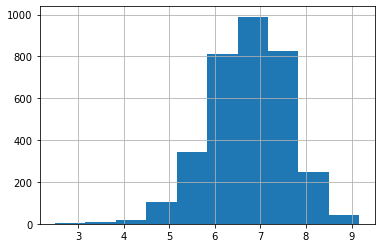

In [70]:
# histogram week 3

# Visualizing histogram for the Score column

new_anime_data['Score'].hist()

<AxesSubplot:>

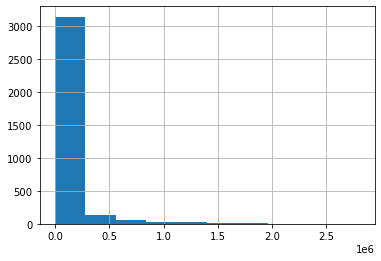

In [71]:
# Visualizing histogram for the Member column

new_anime_data['Member'].hist()

In [72]:
# Visualizing histogram for the Number of Episodes column
# ex: values = [1, 25, 50, 75]
# plt.plot(x,y,marker="o")
# plt.xlabel("X-Axis")
# plt.ylabel("Y-Axis")
# plt.title("Set X labels in Matplotlib Plot")
# plt.xticks(x,values)
# plt.show()
import matplotlib.pyplot as plt

# values = [1, 12, 13, 24, 25, 50]

# plt.plot(new_anime_data['Anime Title'],new_anime_data['Number of Episodes'],marker="o")
# plt.xlabel("Number of Episodes")
# plt.ylabel("Total number of Anime")
# plt.title("Total number of Anime with Number of Episodes")
# plt.xticks(new_anime_data['Number of Episodes'],values, rotation = 'vertical')

# new_anime_data['Number of Episodes'].plot(kind="histogram")
# new_anime_data['Number of Episodes'].hist()

C:\Users\MaNinjaChan\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 12539 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MaNinjaChan\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 12539 missing from current font.
  font.set_text(s, 0, flags=flags)


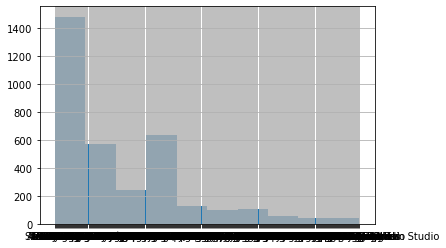

In [73]:
# Visualizing histogram for the Producer column
new_anime_data['Producer'].hist()

import matplotlib.pyplot as plt
import numpy as np

# Making Axis Label Vertical
# x = np.arange(0, 10, 0.1)
# y = np.sin(x)

# plt.plot(x, y)
# plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
# plt.show()

<AxesSubplot:>

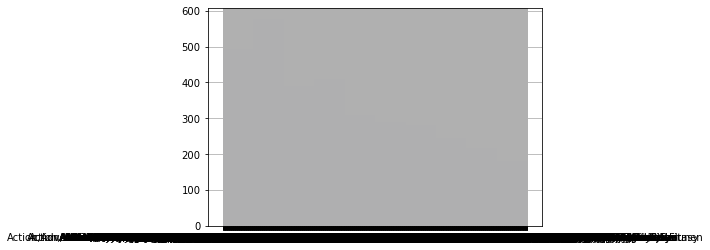

In [74]:
# Visualizing histogram for the Genre column

new_anime_data['Genre'].hist()

<AxesSubplot:>

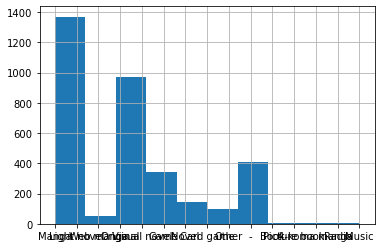

In [75]:
# Visualizing histogram for the Sources column

new_anime_data['Sources'].hist()

In [76]:
# Visualizing histogram for the Format column
# new_anime_data['Format'].hist()



In [77]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# plt.style.use('seaborn-white')
# plt.hist(new_anime_data, bins=10,normed=True,alpha=0.5,histtype='stepfilled');
# a = new_anime_data.hstack((new_anime_data.normal(size=1000),
#                new_anime_data.normal(loc=5, scale=2, size=1000)))
# _ = plt.hist(a, bins='auto')  # arguments are passed to np.histogram
# plt.title("Histogram with 'auto' bins")
# Text(0.5, 1.0, "Histogram with 'auto' bins")
# plt.show()

# plt.xticks(rotation=90)

# for tick in ax.get_xticklabels():
#     tick.set_rotation(45)

## Boxplot

<AxesSubplot:>

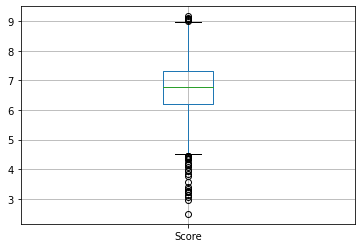

In [78]:
# boxplot week 4

# Visualizing boxplot for the Format column

new_anime_data.boxplot(column=['Score'])

<AxesSubplot:>

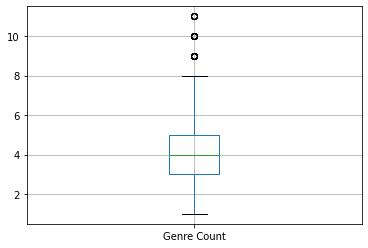

In [79]:
# Changed Number of Episodes Column into int datatype

new_anime_data['Genre Count'] = new_anime_data['Genre Count'].apply(pd.to_numeric, errors='coerce')

# Visualizing boxplot for the Genre Count column

new_anime_data.boxplot(column=['Genre Count'])

<AxesSubplot:>

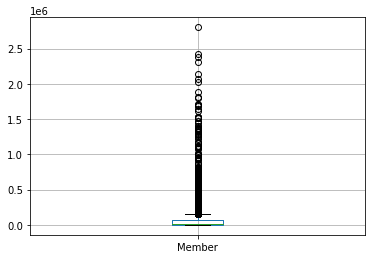

In [80]:
# Visualizing boxplot for the Format column

new_anime_data.boxplot(column=['Member'])

<AxesSubplot:>

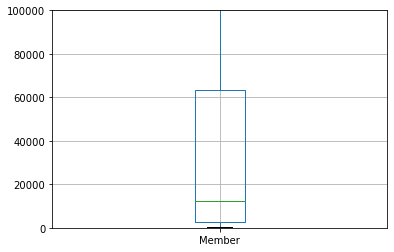

In [81]:
import matplotlib.pyplot as plt

# Added a y-axis limit from over 2,000,000 to 100,000 
plt.ylim(0, 100000)

# Visualizing boxplot for the Member column

new_anime_data.boxplot(column=['Member'])

#### Number of Episodes Cleaning

In [82]:
# Changing Number of Episodes Column datatype from Object to Integer
# In Number of Episodes column, remove all the “,” characters in your member 
# column and print the first 5 rows of data.

new_anime_data['Number of Episodes'] = new_anime_data['Number of Episodes'].replace(' eps','', regex=True)

new_anime_data.head()

,Anime Title,Date of Release,Score,Member,Producer,Genre,Number of Episodes,Sources,Format,Licensor,Format0,Genre0,Genre1,Genre2,Genre3,Genre4,Genre Count
0,Shingeki no Kyojin,"Apr 7, 2013, 01:58 (JST)",8.50,2801951,Wit Studio,"Action,Military,Mystery,Super Power,Drama,Fant...",25,Manga,"TV - Apr 7, 2013,...","Funimation,",TV,Action,Military,Mystery,Super Power,Drama,7
1,Fullmetal Alchemist: Brotherhood,"Apr 5, 2009, 17:00 (JST)",9.17,2424903,Bones,"Action,Military,Adventure,Comedy,Drama,Magic,F...",64,Manga,"TV - Apr 5, 2009,...","Aniplex of America,Funimation,",TV,Action,Military,Adventure,Comedy,Drama,8
2,Sword Art Online,"Jul 8, 2012, 00:00 (JST)",7.22,2375868,A-1 Pictures,"Action,Game,Adventure,Romance,Fantasy",25,Light novel,"TV - Jul 8, 2012,...","Aniplex of America,",TV,Action,Game,Adventure,Romance,Fantasy,5
3,One Punch Man,"Oct 5, 2015, 01:05 (JST)",8.55,2308824,Madhouse,"Action,Sci-Fi,Comedy,Parody,Super Power,Supern...",12,Web manga,"TV - Oct 5, 2015,...","VIZ Media,",TV,Action,Sci-Fi,Comedy,Parody,Super Power,6
4,Boku no Hero Academia,"Apr 3, 2016, 17:00 (JST)",8.05,2139153,Bones,"Action,Comedy,School,Shounen,Super Power",13,Manga,"TV - Apr 3, 2016,...","Funimation,",TV,Action,Comedy,School,Shounen,Super Power,5


<AxesSubplot:>

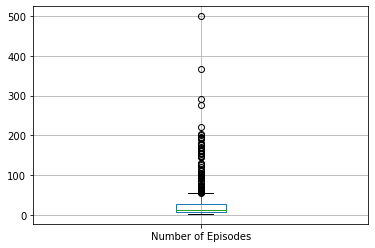

In [83]:
# Changed Number of Episodes Column into int datatype

new_anime_data['Number of Episodes'] = new_anime_data['Number of Episodes'].apply(pd.to_numeric, errors='coerce')

# Visualizing boxplot for the Number of Episodes column

new_anime_data.boxplot(column=['Number of Episodes'])

<AxesSubplot:>

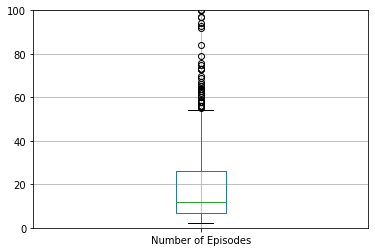

In [84]:
import matplotlib.pyplot as plt

# Added a y-axis limit from 500 to 100 
plt.ylim(0, 100)

# Visualizing boxplot for the Number of Episodes column

new_anime_data.boxplot(column=['Number of Episodes'])

### Summary Statistics Number of Episodes

In [85]:
# Summary stats for column Number of Episodes

new_anime_data['Number of Episodes'].describe()

count    2007.000000
mean       21.474838
std        28.650022
min         2.000000
25%         7.000000
50%        12.000000
75%        26.000000
max       500.000000
Name: Number of Episodes, dtype: float64

In [86]:
new_anime_data2.head()

,Anime Title,Date of Release,Score,Member,Producer,Genre,Number of Episodes,Sources,Format,Licensor,Format0,Genre0,Genre1,Genre2,Genre3,Genre4,Genre Count,Licensor0,Licensor1,Licensor2
0,Shingeki no Kyojin,"Apr 7, 2013, 01:58 (JST)",8.50,2801951,Wit Studio,"Action,Military,Mystery,Super Power,Drama,Fant...",25 eps,Manga,"TV - Apr 7, 2013,...","Funimation,",TV,Action,Military,Mystery,Super Power,Drama,7,Funimation,,NaN
1,Fullmetal Alchemist: Brotherhood,"Apr 5, 2009, 17:00 (JST)",9.17,2424903,Bones,"Action,Military,Adventure,Comedy,Drama,Magic,F...",64 eps,Manga,"TV - Apr 5, 2009,...","Aniplex of America,Funimation,",TV,Action,Military,Adventure,Comedy,Drama,8,Aniplex of America,Funimation,
2,Sword Art Online,"Jul 8, 2012, 00:00 (JST)",7.22,2375868,A-1 Pictures,"Action,Game,Adventure,Romance,Fantasy",25 eps,Light novel,"TV - Jul 8, 2012,...","Aniplex of America,",TV,Action,Game,Adventure,Romance,Fantasy,5,Aniplex of America,,NaN
3,One Punch Man,"Oct 5, 2015, 01:05 (JST)",8.55,2308824,Madhouse,"Action,Sci-Fi,Comedy,Parody,Super Power,Supern...",12 eps,Web manga,"TV - Oct 5, 2015,...","VIZ Media,",TV,Action,Sci-Fi,Comedy,Parody,Super Power,6,VIZ Media,,NaN
4,Boku no Hero Academia,"Apr 3, 2016, 17:00 (JST)",8.05,2139153,Bones,"Action,Comedy,School,Shounen,Super Power",13 eps,Manga,"TV - Apr 3, 2016,...","Funimation,",TV,Action,Comedy,School,Shounen,Super Power,5,Funimation,,NaN


In [87]:
# pivot table week 4
# Score, Producer

import numpy as np

new_anime_data_mini=new_anime_data2[(new_anime_data2['Licensor0']=='Funimation')|
                                   (new_anime_data2['Licensor0']=='Sentai Filmworks')|
                                   (new_anime_data2['Licensor0']=='Discotek Media')|
                                   (new_anime_data2['Licensor0']=='ADV Films')|
                                   (new_anime_data2['Licensor0']=='Aniplex of America')|
                                   (new_anime_data2['Genre1']=='Adventure')|
                                   (new_anime_data2['Genre1']=='Sci-Fi')|
                                   (new_anime_data2['Genre1']=='Comedy')|
                                   (new_anime_data2['Genre1']=='Military')|
                                   (new_anime_data2['Genre1']=='Fantasy')|
                                   (new_anime_data2['Genre1']=='Drama')|
                                   (new_anime_data2['Genre1']=='Mecha')|
                                   (new_anime_data2['Genre1']=='Mystery')|
                                   (new_anime_data2['Genre1']=='Historical')|
                                   (new_anime_data2['Genre1']=='Game')|
                                   (new_anime_data2['Producer']=='Toei Animation')|
                                   (new_anime_data2['Producer']=='Sunrise')|
                                   (new_anime_data2['Producer']=='Madhouse')|
                                   (new_anime_data2['Producer']=='Production I.G')|
                                   (new_anime_data2['Producer']=='J.C.Staff')|
                                   (new_anime_data2['Sources']=='Original')|
                                   (new_anime_data2['Sources']=='Game')|
                                   (new_anime_data2['Sources']=='Light novel')|
                                   (new_anime_data2['Sources']=='Novel')|
                                   (new_anime_data2['Sources']=='Visual novel')]

table = pd.pivot_table(new_anime_data_mini, values=['Score','Member'],index=['Producer','Sources'],
                      aggfunc={'Score':np.mean,'Member':np.mean})
print(table)

                             Member     Score
Producer Sources                             
8bit     -             5.809000e+03  6.560000
         Game          8.664500e+03  6.360000
         Light novel   2.942325e+05  7.142308
         Manga         1.424700e+05  7.470000
         Original      6.143875e+04  7.190000
...                             ...       ...
ufotable Game          1.147597e+05  7.114000
         Light novel   2.930860e+05  7.860833
         Manga         1.116175e+06  8.695000
         Original      1.821600e+04  6.650000
         Visual novel  3.532841e+05  8.248571

[679 rows x 2 columns]


In [88]:
#Checking for correlation between numeric variables

anime_numeric=new_anime_data[['Score','Member','Number of Episodes']]
anime_numeric.corr()

,Score,Member,Number of Episodes
Score,1.000000,0.402133,0.167510
Member,0.402133,1.000000,0.177764
Number of Episodes,0.167510,0.177764,1.000000


In [89]:
# bar chart
# Number of genres, Licensor, Producer, 

# df = pd.DataFrame({'lab':['A', 'B', 'C'], 'val':[10, 30, 20]})
# ax = df.plot.bar(x='lab', y='val', rot=0)

# Part II Project

## Subset Dataset

In [90]:
# Subsetting the rows 0 - 300 into a new dataset
small_anime_data = new_anime_data2[0:300]
small_anime_data.head()

,Anime Title,Date of Release,Score,Member,Producer,Genre,Number of Episodes,Sources,Format,Licensor,Format0,Genre0,Genre1,Genre2,Genre3,Genre4,Genre Count,Licensor0,Licensor1,Licensor2
0,Shingeki no Kyojin,"Apr 7, 2013, 01:58 (JST)",8.50,2801951,Wit Studio,"Action,Military,Mystery,Super Power,Drama,Fant...",25 eps,Manga,"TV - Apr 7, 2013,...","Funimation,",TV,Action,Military,Mystery,Super Power,Drama,7,Funimation,,NaN
1,Fullmetal Alchemist: Brotherhood,"Apr 5, 2009, 17:00 (JST)",9.17,2424903,Bones,"Action,Military,Adventure,Comedy,Drama,Magic,F...",64 eps,Manga,"TV - Apr 5, 2009,...","Aniplex of America,Funimation,",TV,Action,Military,Adventure,Comedy,Drama,8,Aniplex of America,Funimation,
2,Sword Art Online,"Jul 8, 2012, 00:00 (JST)",7.22,2375868,A-1 Pictures,"Action,Game,Adventure,Romance,Fantasy",25 eps,Light novel,"TV - Jul 8, 2012,...","Aniplex of America,",TV,Action,Game,Adventure,Romance,Fantasy,5,Aniplex of America,,NaN
3,One Punch Man,"Oct 5, 2015, 01:05 (JST)",8.55,2308824,Madhouse,"Action,Sci-Fi,Comedy,Parody,Super Power,Supern...",12 eps,Web manga,"TV - Oct 5, 2015,...","VIZ Media,",TV,Action,Sci-Fi,Comedy,Parody,Super Power,6,VIZ Media,,NaN
4,Boku no Hero Academia,"Apr 3, 2016, 17:00 (JST)",8.05,2139153,Bones,"Action,Comedy,School,Shounen,Super Power",13 eps,Manga,"TV - Apr 3, 2016,...","Funimation,",TV,Action,Comedy,School,Shounen,Super Power,5,Funimation,,NaN


In [91]:
# Getting the basic info of the subsetted dataset

small_anime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Anime Title         300 non-null    object 
 1   Date of Release     300 non-null    object 
 2   Score               300 non-null    float64
 3   Member              300 non-null    int64  
 4   Producer            300 non-null    object 
 5   Genre               300 non-null    object 
 6   Number of Episodes  300 non-null    object 
 7   Sources             300 non-null    object 
 8   Format              300 non-null    object 
 9   Licensor            300 non-null    object 
 10  Format0             300 non-null    object 
 11  Genre0              300 non-null    object 
 12  Genre1              300 non-null    object 
 13  Genre2              296 non-null    object 
 14  Genre3              269 non-null    object 
 15  Genre4              212 non-null    object 
 16  Genre Co

#### Reorder Rows by Score Highest to Lowest

In [92]:
# Changing order of column rows based on Member count to Score from highest to 
#lowest

re_small = small_anime_data.sort_values(by=['Score'], ascending = False)
re_small.head()

,Anime Title,Date of Release,Score,Member,Producer,Genre,Number of Episodes,Sources,Format,Licensor,Format0,Genre0,Genre1,Genre2,Genre3,Genre4,Genre Count,Licensor0,Licensor1,Licensor2
1,Fullmetal Alchemist: Brotherhood,"Apr 5, 2009, 17:00 (JST)",9.17,2424903,Bones,"Action,Military,Adventure,Comedy,Drama,Magic,F...",64 eps,Manga,"TV - Apr 5, 2009,...","Aniplex of America,Funimation,",TV,Action,Military,Adventure,Comedy,Drama,8,Aniplex of America,Funimation,
32,Shingeki no Kyojin Season 3 Part 2,"Apr 29, 2019, 00:10 (JST)",9.11,1312512,Wit Studio,"Action,Drama,Fantasy,Military,Mystery,Shounen,...",10 eps,Manga,"TV - Apr 29, 2019...","Funimation,",TV,Action,Drama,Fantasy,Military,Mystery,7,Funimation,,NaN
166,Gintama°,"Apr 8, 2015, 18:00 (JST)",9.09,435592,Bandai Namco Pictures,"Action,Comedy,Historical,Parody,Samurai,Sci-Fi...",51 eps,Manga,"TV - Apr 8, 2015,...","Crunchyroll,Funimation,",TV,Action,Comedy,Historical,Parody,Samurai,7,Crunchyroll,Funimation,
7,Hunter x Hunter (2011),"Oct 2, 2011, 10:55 (JST)",9.08,1885151,Madhouse,"Action,Adventure,Fantasy,Shounen,Super Power",148 eps,Manga,"TV - Oct 2, 2011,...","VIZ Media,",TV,Action,Adventure,Fantasy,Shounen,Super Power,5,VIZ Media,,NaN
183,Gintama',"Apr 4, 2011, 18:00 (JST)",9.06,391806,Sunrise,"Action,Sci-Fi,Comedy,Historical,Parody,Samurai...",51 eps,Manga,"TV - Apr 4, 2011,...",,TV,Action,Sci-Fi,Comedy,Historical,Parody,7,,NaN,NaN


#### Reindex Rows

#### Top 20 Anime

In [93]:
#Reset index of subsetted dataset
# Displaying the top 5 anime rows of reindexed subsetted dataset

re_small.reset_index(drop=True, inplace=True)
re_small.head(20)

,Anime Title,Date of Release,Score,Member,Producer,Genre,Number of Episodes,Sources,Format,Licensor,Format0,Genre0,Genre1,Genre2,Genre3,Genre4,Genre Count,Licensor0,Licensor1,Licensor2
0,Fullmetal Alchemist: Brotherhood,"Apr 5, 2009, 17:00 (JST)",9.17,2424903,Bones,"Action,Military,Adventure,Comedy,Drama,Magic,F...",64 eps,Manga,"TV - Apr 5, 2009,...","Aniplex of America,Funimation,",TV,Action,Military,Adventure,Comedy,Drama,8,Aniplex of America,Funimation,
1,Shingeki no Kyojin Season 3 Part 2,"Apr 29, 2019, 00:10 (JST)",9.11,1312512,Wit Studio,"Action,Drama,Fantasy,Military,Mystery,Shounen,...",10 eps,Manga,"TV - Apr 29, 2019...","Funimation,",TV,Action,Drama,Fantasy,Military,Mystery,7,Funimation,,NaN
2,Gintama°,"Apr 8, 2015, 18:00 (JST)",9.09,435592,Bandai Namco Pictures,"Action,Comedy,Historical,Parody,Samurai,Sci-Fi...",51 eps,Manga,"TV - Apr 8, 2015,...","Crunchyroll,Funimation,",TV,Action,Comedy,Historical,Parody,Samurai,7,Crunchyroll,Funimation,
3,Hunter x Hunter (2011),"Oct 2, 2011, 10:55 (JST)",9.08,1885151,Madhouse,"Action,Adventure,Fantasy,Shounen,Super Power",148 eps,Manga,"TV - Oct 2, 2011,...","VIZ Media,",TV,Action,Adventure,Fantasy,Shounen,Super Power,5,VIZ Media,,NaN
4,Gintama',"Apr 4, 2011, 18:00 (JST)",9.06,391806,Sunrise,"Action,Sci-Fi,Comedy,Historical,Parody,Samurai...",51 eps,Manga,"TV - Apr 4, 2011,...",,TV,Action,Sci-Fi,Comedy,Historical,Parody,7,,NaN,NaN
5,Gintama': Enchousen,"Oct 4, 2012, 18:00 (JST)",9.03,237232,Sunrise,"Action,Comedy,Historical,Parody,Samurai,Sci-Fi...",13 eps,Manga,"TV - Oct 4, 2012,...",,TV,Action,Comedy,Historical,Parody,Samurai,7,,NaN,NaN
6,Shingeki no Kyojin: The Final Season,"Dec 7, 2020, 00:10 (JST)",9.02,1072333,MAPPA,"Action,Military,Mystery,Super Power,Drama,Fant...",16 eps,Manga,"TV - Dec 7, 2020,...","Funimation,",TV,Action,Military,Mystery,Super Power,Drama,7,Funimation,,NaN
7,Gintama,"Apr 4, 2006, 18:00 (JST)",8.95,807271,Sunrise,"Action,Comedy,Historical,Parody,Samurai,Sci-Fi...",201 eps,Manga,"TV - Apr 4, 2006,...","Crunchyroll,Sentai Filmworks,",TV,Action,Comedy,Historical,Parody,Samurai,7,Crunchyroll,Sentai Filmworks,
8,Code Geass: Hangyaku no Lelouch R2,"Apr 6, 2008, 17:00 (JST)",8.91,1352271,Sunrise,"Action,Military,Sci-Fi,Super Power,Drama,Mecha",25 eps,Original,"TV - Apr 6, 2008,...","Bandai Entertainment,Funimation,",TV,Action,Military,Sci-Fi,Super Power,Drama,6,Bandai Entertainment,Funimation,
9,Mob Psycho 100 II,"Jan 7, 2019, 23:00 (JST)",8.83,942641,Bones,"Action,Slice of Life,Comedy,Supernatural",13 eps,Web manga,"TV - Jan 7, 2019,...","Funimation,",TV,Action,Slice of Life,Comedy,Supernatural,NaN,4,Funimation,,NaN


#### Lowest 20 Anime

In [94]:
# Displaying the bottom 5 anime rows of reindexed subsetted dataset

re_small.tail(20)

,Anime Title,Date of Release,Score,Member,Producer,Genre,Number of Episodes,Sources,Format,Licensor,Format0,Genre0,Genre1,Genre2,Genre3,Genre4,Genre Count,Licensor0,Licensor1,Licensor2
280,Shinmai Maou no Testament,"Jan 8, 2015, 02:00 (JST)",6.77,509792,Production IMS,"Action,Ecchi,Fantasy,Romance,Harem,Demons",12 eps,Light novel,"TV - Jan 8, 2015,...","Crunchyroll,Funimation,",TV,Action,Ecchi,Fantasy,Romance,Harem,6,Crunchyroll,Funimation,
281,Sword Art Online II,"Jul 5, 2014, 00:00 (JST)",6.75,1529071,A-1 Pictures,"Action,Game,Adventure,Romance,Fantasy",24 eps,Light novel,"TV - Jul 5, 2014,...","Aniplex of America,",TV,Action,Game,Adventure,Romance,Fantasy,5,Aniplex of America,,NaN
282,IS: Infinite Stratos,"Jan 7, 2011, 01:25 (JST)",6.71,527657,8bit,"Action,Sci-Fi,Harem,Comedy,Ecchi,Mecha",12 eps,Light novel,"TV - Jan 7, 2011,...","Sentai Filmworks,",TV,Action,Sci-Fi,Harem,Comedy,Ecchi,6,Sentai Filmworks,,NaN
283,Saijaku Muhai no Bahamut,"Jan 11, 2016, 22:30 (JST)",6.59,299100,Lerche,"Action,Harem,Supernatural,Romance,Ecchi,Fantas...",12 eps,Light novel,"TV - Jan 11, 2016...","Sentai Filmworks,",TV,Action,Harem,Supernatural,Romance,Ecchi,8,Sentai Filmworks,,NaN
284,Sword Art Online: Extra Edition,"Dec 31, 2013",6.58,255383,A-1 Pictures,"Action,Adventure,Fantasy,Game,Romance",1 ep,Light novel,"Special - Dec 31,...","Aniplex of America,",Special,Action,Adventure,Fantasy,Game,Romance,5,Aniplex of America,,NaN
285,Arifureta Shokugyou de Sekai Saikyou,"Jul 8, 2019, 23:30 (JST)",6.57,400737,Asread,"Action,Adventure,Fantasy,Harem",13 eps,Light novel,"TV - Jul 8, 2019,...","Funimation,",TV,Action,Adventure,Fantasy,Harem,NaN,4,Funimation,,NaN
286,Kenja no Mago,"Apr 10, 2019, 23:30 (JST)",6.55,368186,SILVER LINK.,"Action,Comedy,Magic,Romance,Fantasy",12 eps,Light novel,"TV - Apr 10, 2019...","Funimation,",TV,Action,Comedy,Magic,Romance,Fantasy,5,Funimation,,NaN
287,Blood-C,"Jul 8, 2011",6.54,273117,Production I.G,"Action,Mystery,Horror,Supernatural,Vampire,School",12 eps,Manga,"TV - Jul 8, 2011 ...","Funimation,",TV,Action,Mystery,Horror,Supernatural,Vampire,6,Funimation,,NaN
288,IS: Infinite Stratos 2,"Oct 4, 2013, 01:58 (JST)",6.52,320905,8bit,"Action,Sci-Fi,Harem,Comedy,Ecchi,Mecha",12 eps,Light novel,"TV - Oct 4, 2013,...","Sentai Filmworks,",TV,Action,Sci-Fi,Harem,Comedy,Ecchi,6,Sentai Filmworks,,NaN
289,Plunderer,"Jan 9, 2020, 01:05 (JST)",6.52,248987,GEEK TOYS,"Action,Ecchi,Fantasy,Shounen",24 eps,Manga,"TV - Jan 9, 2020,...","Funimation,",TV,Action,Ecchi,Fantasy,Shounen,NaN,4,Funimation,,NaN


#### Chosen titles of top and bottom 5 that can be found on MyAnimeList and Crunchyroll

#### Top: 
#### - Fullmetal Alchemist
#### - Hunter x Hunter (2011)
#### - Jujutsu Kaisen
#### - Cowboy Bebop
#### - Gurren Lagann

#### Bottom:
#### - Boruto: Naruto Next Generations
#### - Hundred
#### - Kampfer
#### - Dragon Ball GT
#### - Absolute Duo

In [95]:
top1=re_small.loc[re_small['Anime Title']=='Fullmetal Alchemist: Brotherhood']
top2=re_small.loc[re_small['Anime Title']=='Hunter x Hunter (2011)']
top3=re_small.loc[re_small['Anime Title']=='Jujutsu Kaisen (TV)']
top4=re_small.loc[re_small['Anime Title']=='Cowboy Bebop']
top5=re_small.loc[re_small['Anime Title']=='Tengen Toppa Gurren Lagann']
print(top3)

            Anime Title           Date of Release  Score   Member Producer  \
12  Jujutsu Kaisen (TV)  Oct 3, 2020, 01:25 (JST)   8.78  1106247    MAPPA   

                                        Genre Number of Episodes Sources  \
12  Action,Demons,Supernatural,School,Shounen             24 eps   Manga   

                                               Format Licensor    Format0  \
12        TV -                        Oct 3, 2020,...                 TV    

    Genre0  Genre1        Genre2  Genre3   Genre4 Genre Count Licensor0  \
12  Action  Demons  Supernatural  School  Shounen           5             

   Licensor1 Licensor2  
12       NaN       NaN  


In [96]:
top = top1
top = top.append(top2)
top = top.append(top3)
top = top.append(top4)
top = top.append(top5)
top.head()

,Anime Title,Date of Release,Score,Member,Producer,Genre,Number of Episodes,Sources,Format,Licensor,Format0,Genre0,Genre1,Genre2,Genre3,Genre4,Genre Count,Licensor0,Licensor1,Licensor2
0,Fullmetal Alchemist: Brotherhood,"Apr 5, 2009, 17:00 (JST)",9.17,2424903,Bones,"Action,Military,Adventure,Comedy,Drama,Magic,F...",64 eps,Manga,"TV - Apr 5, 2009,...","Aniplex of America,Funimation,",TV,Action,Military,Adventure,Comedy,Drama,8,Aniplex of America,Funimation,
3,Hunter x Hunter (2011),"Oct 2, 2011, 10:55 (JST)",9.08,1885151,Madhouse,"Action,Adventure,Fantasy,Shounen,Super Power",148 eps,Manga,"TV - Oct 2, 2011,...","VIZ Media,",TV,Action,Adventure,Fantasy,Shounen,Super Power,5,VIZ Media,,NaN
12,Jujutsu Kaisen (TV),"Oct 3, 2020, 01:25 (JST)",8.78,1106247,MAPPA,"Action,Demons,Supernatural,School,Shounen",24 eps,Manga,"TV - Oct 3, 2020,...",,TV,Action,Demons,Supernatural,School,Shounen,5,,NaN,NaN
13,Cowboy Bebop,"Apr 3, 1998, 01:00 (JST)",8.77,1344107,Sunrise,"Action,Adventure,Comedy,Drama,Sci-Fi,Space",26 eps,Original,"TV - Apr 3, 1998,...","Bandai Entertainment,Funimation,",TV,Action,Adventure,Comedy,Drama,Sci-Fi,6,Bandai Entertainment,Funimation,
17,Tengen Toppa Gurren Lagann,"Apr 1, 2007, 08:30 (JST)",8.65,1280231,Gainax,"Action,Sci-Fi,Adventure,Comedy,Mecha",27 eps,Original,"TV - Apr 1, 2007,...","ADV Films,Aniplex of America,Bandai Entertainm...",TV,Action,Sci-Fi,Adventure,Comedy,Mecha,5,ADV Films,Aniplex of America,Bandai Entertainment


In [97]:
bot1=re_small.loc[re_small['Anime Title']=='Boruto: Naruto Next Generations']
bot2=re_small.loc[re_small['Anime Title']=='Hundred']
bot3=re_small.loc[re_small['Anime Title']=='Kämpfer']
bot4=re_small.loc[re_small['Anime Title']=='Dragon Ball GT']
bot5=re_small.loc[re_small['Anime Title']=='Absolute Duo']
bot1.head()

,Anime Title,Date of Release,Score,Member,Producer,Genre,Number of Episodes,Sources,Format,Licensor,Format0,Genre0,Genre1,Genre2,Genre3,Genre4,Genre Count,Licensor0,Licensor1,Licensor2
299,Boruto: Naruto Next Generations,"Apr 5, 2017, 17:30 (JST)",5.79,584841,Studio Pierrot,"Action,Adventure,Super Power,Martial Arts,Shounen",? eps,Manga,"TV - Apr 5, 2017,...","VIZ Media,",TV,Action,Adventure,Super Power,Martial Arts,Shounen,5,VIZ Media,,NaN


In [98]:
bot = bot1
bot = bot.append(bot2)
bot = bot.append(bot3)
bot = bot.append(bot4)
bot = bot.append(bot5)
bot.head()

,Anime Title,Date of Release,Score,Member,Producer,Genre,Number of Episodes,Sources,Format,Licensor,Format0,Genre0,Genre1,Genre2,Genre3,Genre4,Genre Count,Licensor0,Licensor1,Licensor2
299,Boruto: Naruto Next Generations,"Apr 5, 2017, 17:30 (JST)",5.79,584841,Studio Pierrot,"Action,Adventure,Super Power,Martial Arts,Shounen",? eps,Manga,"TV - Apr 5, 2017,...","VIZ Media,",TV,Action,Adventure,Super Power,Martial Arts,Shounen,5,VIZ Media,,NaN
297,Hundred,"Apr 5, 2016, 02:05 (JST)",6.34,288284,Production IMS,"Action,Sci-Fi,Harem,Romance,Ecchi,Mecha,School",12 eps,Light novel,"TV - Apr 5, 2016,...","Crunchyroll,Funimation,",TV,Action,Sci-Fi,Harem,Romance,Ecchi,7,Crunchyroll,Funimation,
294,Kämpfer,"Oct 2, 2009",6.43,243343,Nomad,"Action,Comedy,Ecchi,Romance,School,Shoujo Ai,S...",12 eps,Light novel,"TV - Oct 2, 2009 ...","Sentai Filmworks,",TV,Action,Comedy,Ecchi,Romance,School,7,Sentai Filmworks,,NaN
291,Dragon Ball GT,"Feb 7, 1996, 19:00 (JST)",6.46,500680,Toei Animation,"Action,Sci-Fi,Adventure,Comedy,Super Power,Mag...",64 eps,Manga,"TV - Feb 7, 1996,...","Funimation,",TV,Action,Sci-Fi,Adventure,Comedy,Super Power,8,Funimation,,NaN
290,Absolute Duo,"Jan 4, 2015, 20:30 (JST)",6.49,446650,8bit,"Action,Harem,Supernatural,Romance,Ecchi,School",12 eps,Light novel,"TV - Jan 4, 2015,...","Funimation,",TV,Action,Harem,Supernatural,Romance,Ecchi,6,Funimation,,NaN


#### Check Part 2 Code

In [99]:
# After we found the top and bottom 5 titles from MyAnimeList (that originally matched with titles 
# from Crunchyroll, our next step is Web scraping the reviews of each of the 10 titles

#### Future Plans

In [100]:
# Then, we will do cleaning by removing non english/numeric characters from text, do word count,
# converting all characters to lowercase, count stop words, remove all stopwords, stemming the words,
# and concatenating all the comments into a csv file 

In [101]:
# areviews = ' '.join(df['comm'])
# areviews.to_csv(r'D:\UMD Senior College Work\Spring 2021\INST447-0101\Final Project\Reviews.csv')

In [102]:
# After, we will send the csv file to the professor to run on his LIWC 